# FUNCTIONS

In [3]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user 
!jupyter nbextension enable codefolding/main
!python -m pip install -U notebook-as-pdf
!pyppeteer-install
!jupyter-nbconvert stats_conditions_Salaries.ipynb --no-input --no-prompt --to html

[I 17:43:53 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 17:43:53 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 17:43:53 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.8/dist-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad -> scratchpad
[I 17:43:53 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/LICENSE
[I 17:43:53 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/README.md
[I 17:43:53 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/scratchpad.yaml
[I 17:43:53 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 17:43:53 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/main.js
[I 17:43:53 InstallContribNbextensionsAp

In [1]:
from typing import Tuple
import seaborn as sns
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import describe, pearsonr, zscore, f_oneway, yeojohnson, shapiro, probplot, levene
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
pd.options.mode.chained_assignment = None

def explore(df: pd.DataFrame) -> pd.DataFrame:
    ex1, ex2, ex3 = random.sample(range(len(df)), 3)

    print("Dataframe total rows: ", len(df))
    df_info = pd.DataFrame(data = df.dtypes)
    not_missing_values_total = df.notnull().sum()
    not_missing_values_percent = round(not_missing_values_total/len(df)*100,2).astype(str)+" %"

    return pd.concat([df_info[0].rename("Data Type"),\
            df.T[ex1].rename("Example 1"),\
            df.T[ex2].rename("Example 2"),\
            df.T[ex3].rename("Example 3"),\
            not_missing_values_total.rename("Total Not Missing"), \
            not_missing_values_percent.rename("% of not missing values")], axis=1)

def calculate_pvalues(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues    

def oneway_all_columns(df:pd.DataFrame, target: str) -> pd.DataFrame:
    data = []
    for col in list(df.select_dtypes(include="object").columns):
        F, p = f_oneway(*[ df[df[col] == group][target].to_list()  for group in list(df[col].unique()) ])
        data.append((col, F, p, bool(p < .05)))
    return  pd.DataFrame(data, columns= ["column", "F", "P-value", "Statistically significant (pval < 05)"])

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')            
#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()                  

# DATA

In [2]:
url = 'https://raw.githubusercontent.com/ArmandoDLaRosa/school_data_science/main/data/ds_salaries.xlsx'
df = pd.read_excel(url,index_col=0)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


# EXPLORING
## DATA QTY &  VARIABLES

In [3]:
print("Cantidad de datos - ", len(df))

Cantidad de datos -  607


In [4]:
explore(df)

Dataframe total rows:  607


,Data Type,Example 1,Example 2,Example 3,Total Not Missing,% of not missing values
work_year,int64,2022,2022,2021,607,100.0 %
experience_level,object,MI,MI,EN,607,100.0 %
employment_type,object,FT,FT,FT,607,100.0 %
job_title,object,Data Engineer,Head of Data,Data Analyst,607,100.0 %
salary,int64,45000,30000,80000,607,100.0 %
salary_currency,object,EUR,EUR,USD,607,100.0 %
salary_in_usd,int64,49461,32974,80000,607,100.0 %
employee_residence,object,GR,EE,US,607,100.0 %
remote_ratio,int64,100,100,100,607,100.0 %
company_location,object,GR,EE,US,607,100.0 %


## Outliers / Duplicates

In [5]:
print("outliers per column based on 3 std dev from mean \n")
outliers_df = []
for col in list(df.select_dtypes(include ='number').columns):
    outlier_df = df[(np.abs(zscore(df[col])) >= 3)]
    print(col + "\t\t has outliers: \t\t " + str(len(outlier_df)))if len(outlier_df) > 0  else print(col + "\t\t has no outliers")
    outliers_df.append(outlier_df)

outliers per column based on 3 std dev from mean 

work_year		 has no outliers
salary		 has outliers: 		 7
salary_in_usd		 has outliers: 		 9
remote_ratio		 has no outliers


In [6]:
print("Duplicates analysis considering Nans")
duplicates = df.groupby(df.columns.tolist(), as_index=False, dropna=False).size()
duplicates[duplicates["size"]>1].head(10)  # Size columns tells how many of them are

Duplicates analysis considering Nans


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,size
170,2021,MI,FT,Data Engineer,200000,USD,200000,US,100,US,L,2
183,2021,MI,FT,Data Scientist,76760,EUR,90734,DE,50,DE,L,2
338,2022,MI,FT,Data Analyst,58000,USD,58000,US,0,US,S,2
353,2022,MI,FT,Data Engineer,60000,GBP,78526,GB,100,GB,M,2
393,2022,MI,FT,ETL Developer,50000,EUR,54957,GR,0,GR,M,2
414,2022,SE,FT,Data Analyst,61300,USD,61300,CA,100,CA,M,2
420,2022,SE,FT,Data Analyst,90320,USD,90320,US,100,US,M,5
422,2022,SE,FT,Data Analyst,99000,USD,99000,US,0,US,M,2
424,2022,SE,FT,Data Analyst,100000,USD,100000,US,100,US,M,2
430,2022,SE,FT,Data Analyst,112900,USD,112900,US,100,US,M,4


## TIPO & ESCALA DE MEDICIÓN
* Cualitativos  -  dicotómicos, multicategoría
* Cuantitativos -  continuos, discreto
* Escalas - nominal, ordinal, de intervalo y de razón


### NUMERIC - Cuantitativos

In [7]:
display(describe(df.select_dtypes(include ='number'), axis=0))
display(df.describe())

DescribeResult(nobs=607, minmax=(array([2020, 4000, 2859,    0]), array([    2022, 30400000,   600000,      100])), mean=array([2.02140527e+03, 3.24000063e+05, 1.12297870e+05, 7.09225700e+01]), variance=array([4.79048070e-01, 2.38504005e+12, 5.03493266e+09, 1.65723327e+03]), skewness=array([-0.73399742, 14.01816444,  1.66342134, -0.90198805]), kurtosis=array([ -0.64893332, 245.38276027,   6.29170921,  -0.89083751]))

,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,6.070000e+02,607.000000,607.00000
mean,2021.405272,3.240001e+05,112297.869852,70.92257
std,0.692133,1.544357e+06,70957.259411,40.70913
min,2020.000000,4.000000e+03,2859.000000,0.00000
25%,2021.000000,7.000000e+04,62726.000000,50.00000
50%,2022.000000,1.150000e+05,101570.000000,100.00000
75%,2022.000000,1.650000e+05,150000.000000,100.00000
max,2022.000000,3.040000e+07,600000.000000,100.00000


work_year
moda: 2022 por haber 318 datos
rango: 2
Unique elements qty: 3
Elements example:  [2020, 2021, 2022]

salary
moda: 30400000 por haber 18 datos
rango: 30396000
Unique elements qty: 272
Elements example:  [70000, 260000, 85000, 20000, 150000, 72000, 190000, 11000000, 135000, 125000]

salary_in_usd
moda: 600000 por haber 15 datos
rango: 597141
Unique elements qty: 369
Elements example:  [79833, 260000, 109024, 20000, 150000, 72000, 190000, 35735, 135000, 125000]

remote_ratio
moda: 100 por haber 381 datos
rango: 100
Unique elements qty: 3
Elements example:  [0, 50, 100]



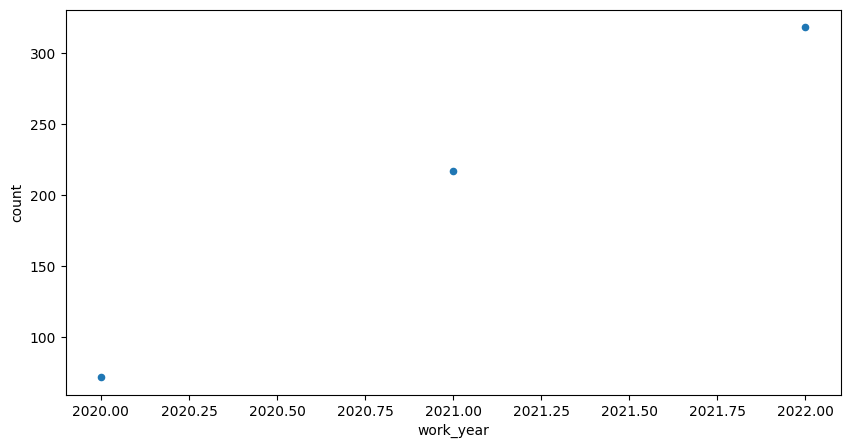

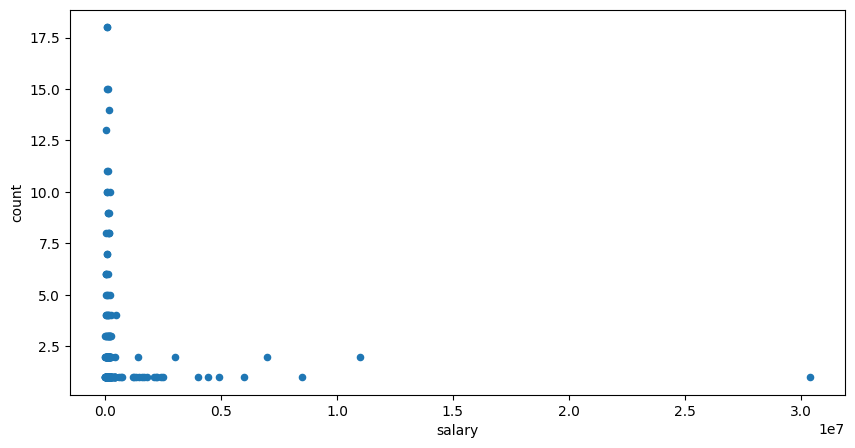

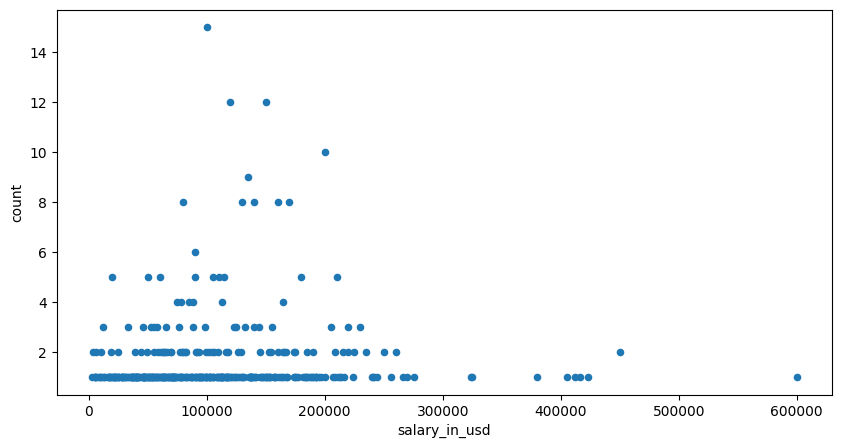

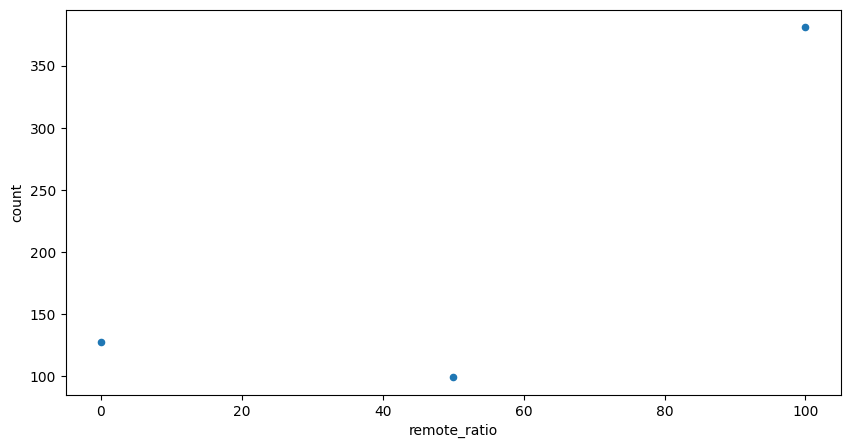

In [8]:
for col in df.select_dtypes(include ='number').columns:
    print(col)
    conteo = df.groupby(by=col).size().reset_index(name="count")
    moda = conteo.max().values
    print(f"moda: {moda[0]} por haber {moda[1]} datos")
    print(f"rango: {df[col].max()-df[col].min()}")
    unique_col = list(df[col].unique())
    print("Unique elements qty: " + str(len(unique_col)))
    print("Elements example:  " + str(unique_col[:10]) + "\n")
    conteo.plot.scatter(x = col, y="count", figsize=[10,5])


*   **work year** discreta - intervalo - moda es 2022
*   **salary** - continua - razon
*   **salary in usd** - continua - razon

Remote Ratio deberia ser cualitativa
*   **remote ratio** -  multicategoria - ordinal

Cuartiles
0.0 	 2020.0
0.25 	 2021.0
0.5 	 2022.0
0.75 	 2022.0
1.0 	 2022.0


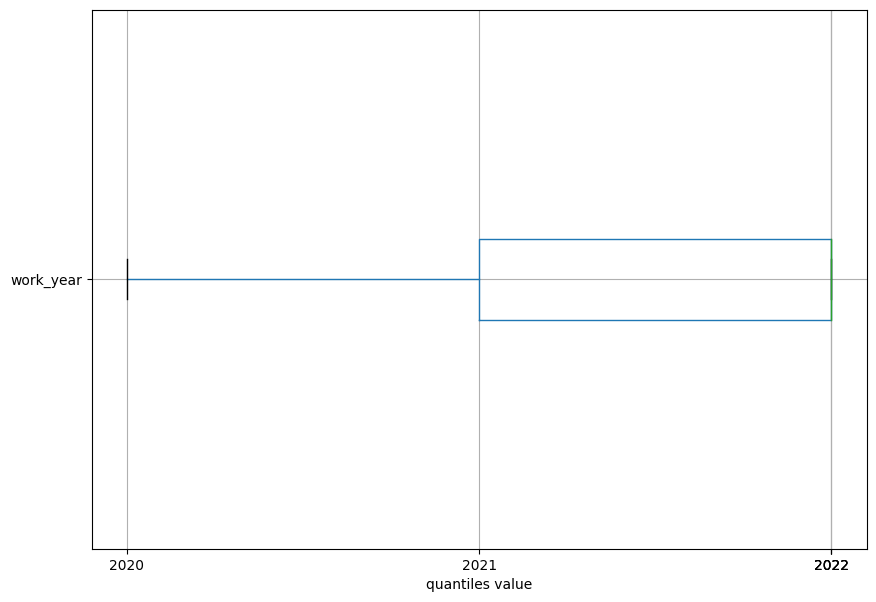

In [9]:
var = df[["work_year"]]
ax = var.boxplot(figsize=[10,7], vert=False)

items = [0.00, 0.25, 0.50, 0.75, 1.00]
quantiles = np.quantile(var, np.array(items))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
ax.set_xlabel('quantiles value')

print("Cuartiles")
for pair in zip(items, quantiles):
    print(pair[0], "\t", pair[1])

plt.show()

Cuartiles
0.0 	 4000.0
0.25 	 70000.0
0.5 	 115000.0
0.75 	 165000.0
1.0 	 30400000.0


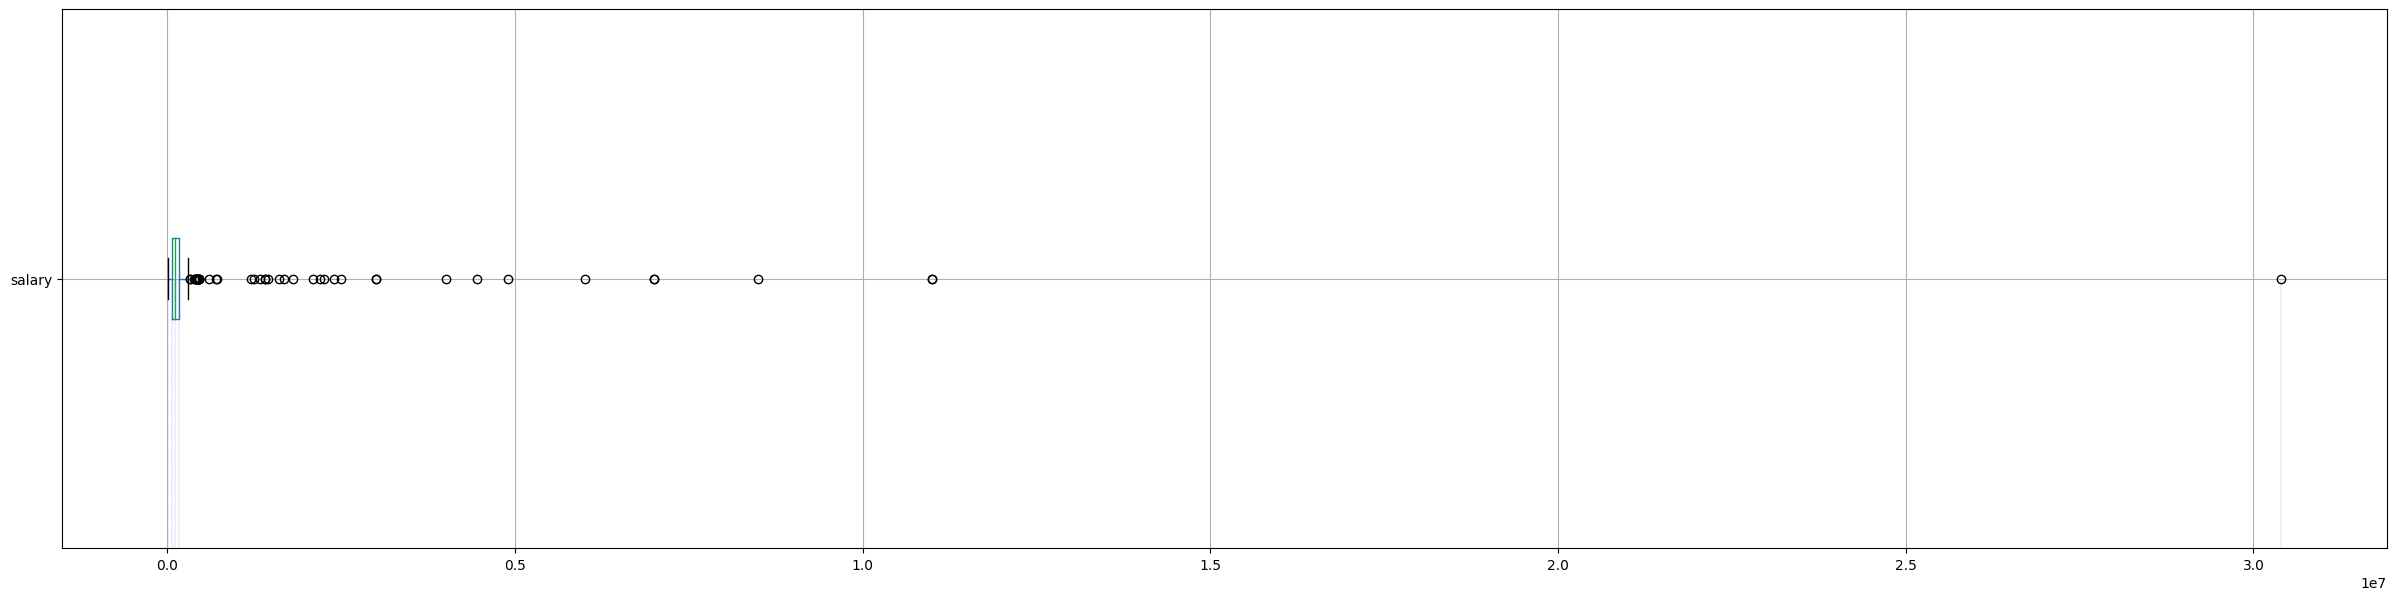

In [10]:
var = df[["salary"]]
ax = var.boxplot(figsize=[30,7], vert=False, manage_ticks=True)

items = [0.00, 0.25, 0.50, 0.75, 1.00]
quantiles = np.quantile(var, np.array(items))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.25, zorder=0)
ax.set_ylim(0.5, 1.5)

print("Cuartiles")
for pair in zip(items, quantiles):
    print(pair[0], "\t", pair[1])
plt.show()

Cuartiles
0.0 	 2859.0
0.25 	 62726.0
0.5 	 101570.0
0.75 	 150000.0
1.0 	 600000.0


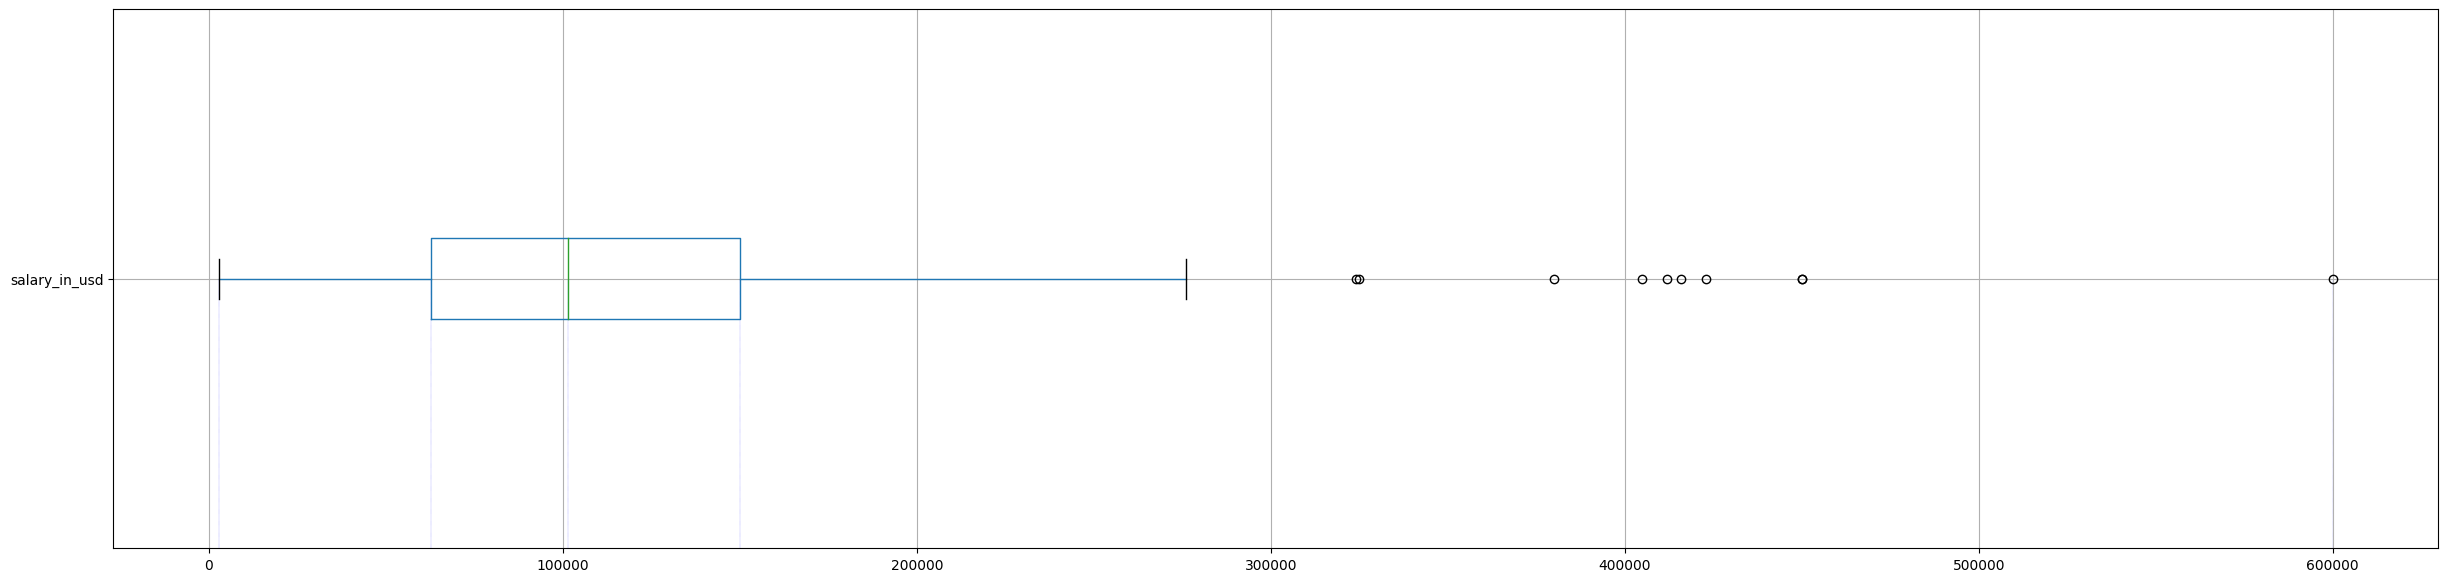

In [11]:
var = df[["salary_in_usd"]]
ax = var.boxplot(figsize=[30,7], vert=False, manage_ticks=True)

items = [0.00, 0.25, 0.50, 0.75, 1.00]
quantiles = np.quantile(var, np.array(items))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.25, zorder=0)
ax.set_ylim(0.5, 1.5)

print("Cuartiles")
for pair in zip(items, quantiles):
    print(pair[0], "\t", pair[1])

plt.show()

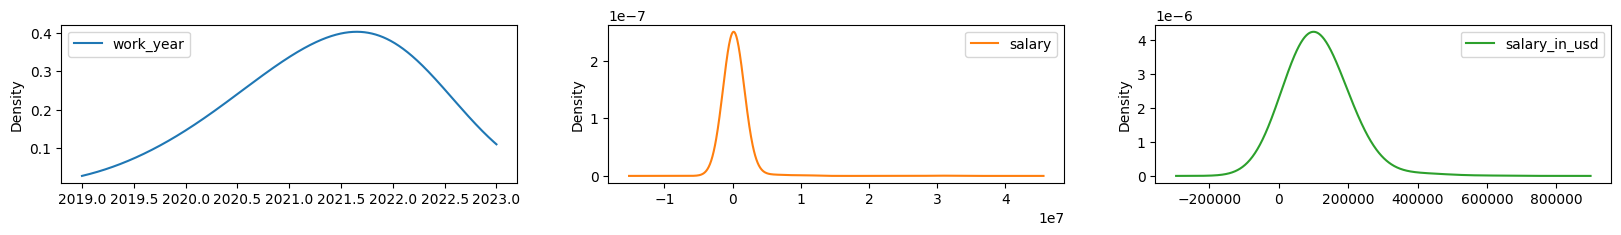

In [12]:
df.select_dtypes(include ='number').drop(columns="remote_ratio").plot.kde(bw_method=1, subplots=True, layout=(3,3), sharex=False, figsize=[20,7])
plt.show()

*   **work year** asímetrico
*   **salary** simétrico
*   **salary in usd** asímetrico

### NON NUMERIC - CUALITATIVE

In [13]:
# Corregir remote_ratio desde que es categórica
df["remote_ratio"] = df["remote_ratio"].astype(str)

In [14]:
display(df.select_dtypes(include ='object').describe(include = 'O').T)

,count,unique,top,freq
experience_level,607,4,SE,280
employment_type,607,4,FT,588
job_title,607,50,Data Scientist,143
salary_currency,607,17,USD,398
employee_residence,607,57,US,332
remote_ratio,607,3,100,381
company_location,607,50,US,355
company_size,607,3,M,326


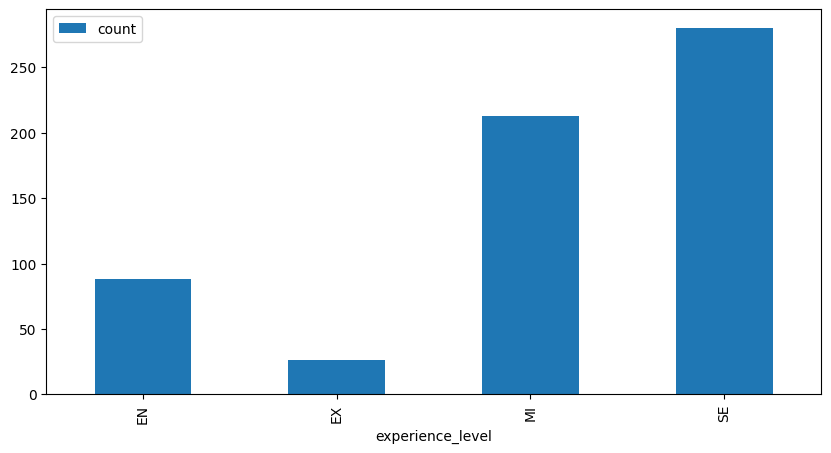

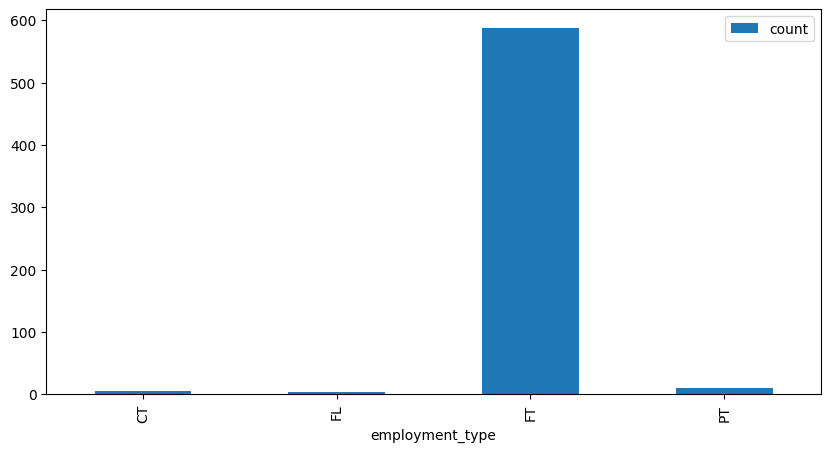

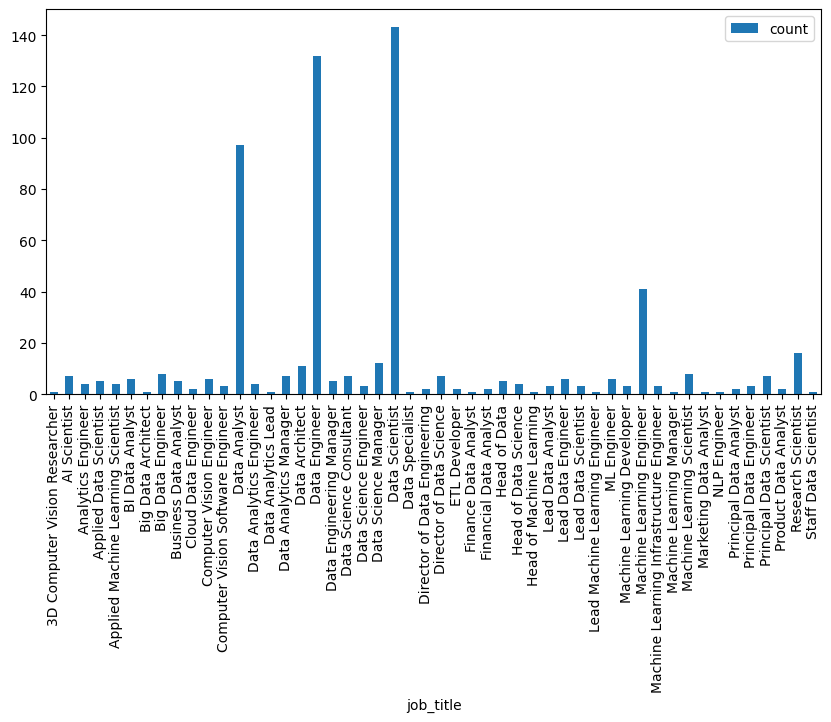

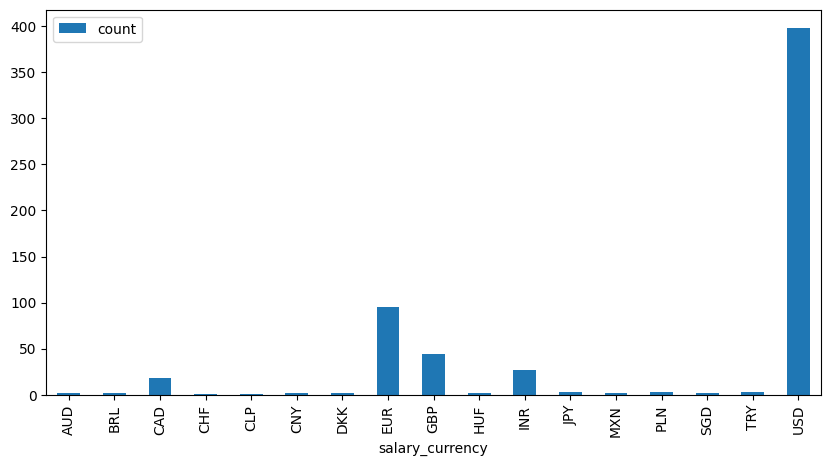

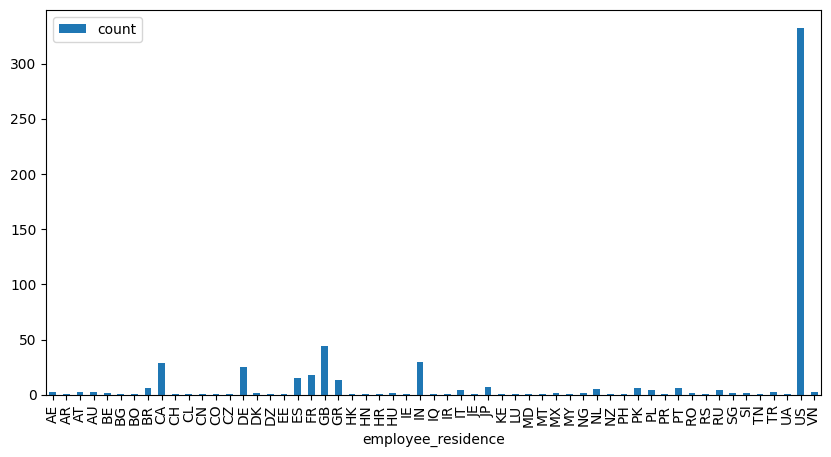

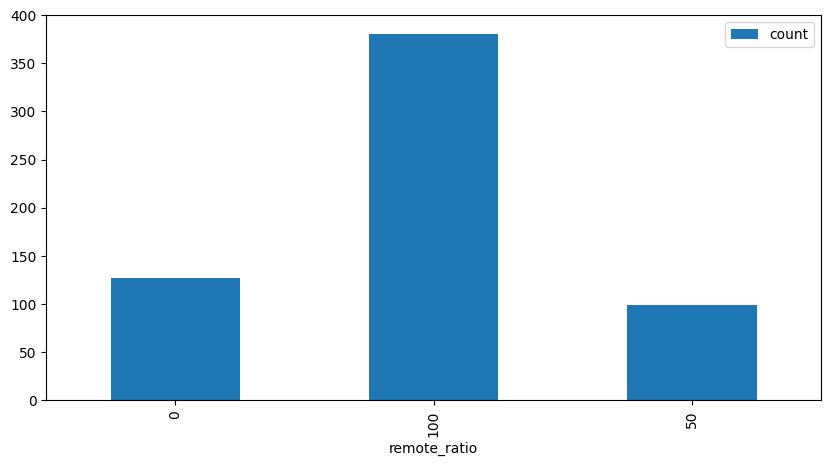

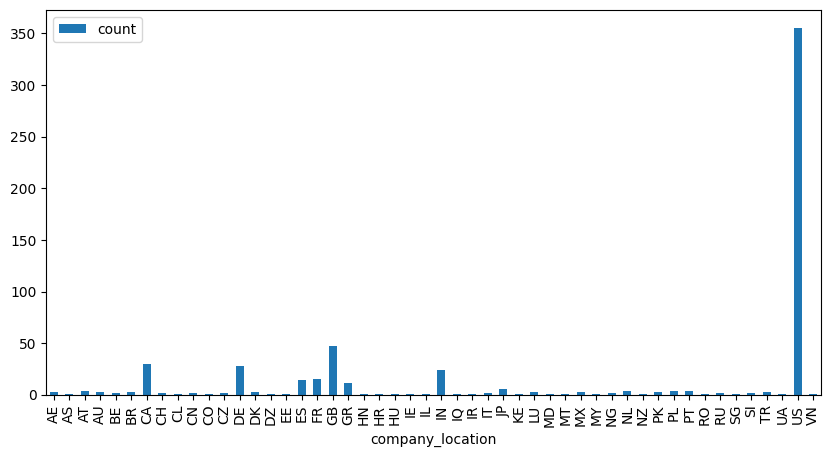

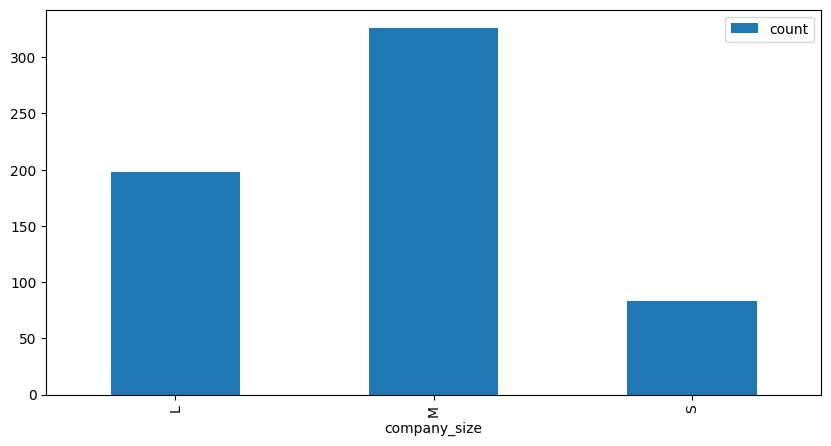

In [15]:
for col in df.select_dtypes(include ='object').columns:
    conteo = df.groupby(by=col).size().reset_index(name="count")
    conteo.plot.bar(x = col, y="count", figsize=[10,5])

* **experience_level** - multi - ordinal
* **employment_type** - multi - nominal
* **job_title** - multi - nominal
* **salary_currency** - multi - nominal
* **employee_residence** - multi - nominal
* **company_location** - -multi - nominal 
* **company_size** - multi - ordinal

# Question Analysis

* ¿Cuál es el salario al que pueda aspirar un analista de datos?
* ¿En qué países se ofrecen mejores salarios?
* ¿Se han incrementado los salarios a lo largo del tiempo?
* ¿Influye el nivel de experiencia en el salario?
* ¿Influye el tamaño de la compañía en el salario que puede ofrecer a un analista de datos?
* ¿Qué tipo de contrato (parcial, tiempo completo, etc) ofrece mejores salarios? ¿Qué tipo de contrato será el más conveniente?
* Otras más que creas que se pueden contestar a partir de la base de datos.

## Preprocessing

En este procesamiento se están limpiando los duplicados que se encontraron al inicio de la exploración del dataset, además se limpieron los outliers que se encontraron en las variables númericas considerando 3 desviaciones estándar.  No se necesitó limpiar las variables categóricas, ya que no tenían datos ingresados de manera incorrecta. Además no se necesitaron rellenar datos. Lo que sí se transformaron los datos para simplificar la comparación del salario y como se detectó que no estaba muy normal su distribución se usó yeojohnson para buscar que fuese normal. 

Las variables seleccionadas fueron las que estarían ayudando a responder la pregunta de que mueve el salario de un científico de datos.

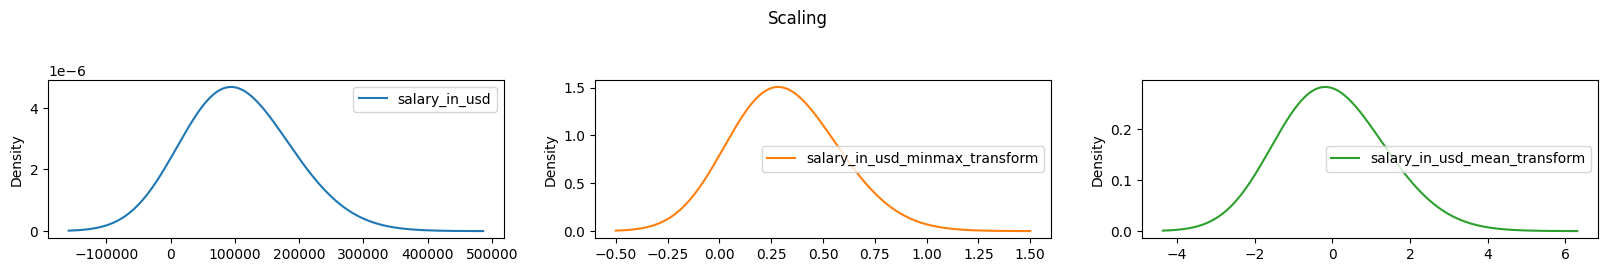

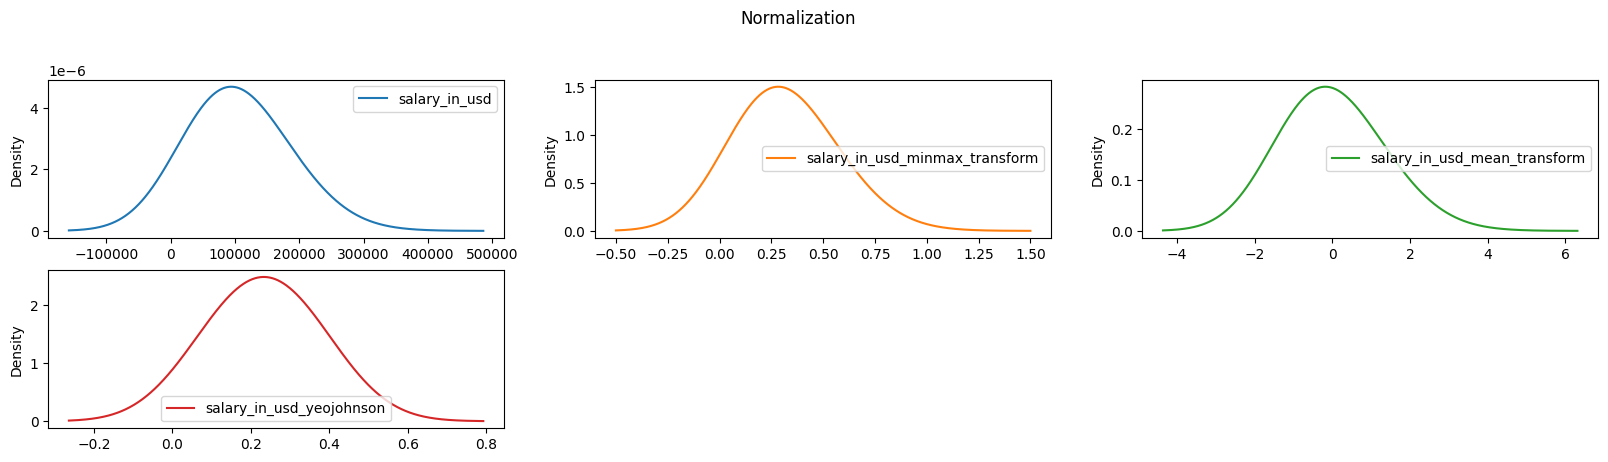

,job_title,salary_in_usd,company_location,work_year,experience_level,company_size,employment_type,salary_in_usd_minmax_transform,salary_in_usd_mean_transform,salary_in_usd_yeojohnson
0,Data Scientist,79833,DE,2020,MI,L,FT,0.238945,-0.419068,0.196443
1,Machine Learning Scientist,260000,JP,2020,SE,S,FT,0.798225,2.566481,0.465472
2,Big Data Engineer,109024,GB,2020,SE,M,FT,0.329561,0.064656,0.253941
3,Product Data Analyst,20000,HN,2020,MI,S,FT,0.053210,-1.410562,0.050753
4,Machine Learning Engineer,150000,US,2020,SE,L,FT,0.456760,0.743670,0.323574


In [16]:
# Selection of variables that will help to answer the questions above
df  = df[["job_title", "salary_in_usd", "company_location", "work_year", "experience_level", "company_size", "employment_type"]]
df["work_year"] = df["work_year"].astype('object')

# Duplicates
df = df.drop_duplicates()

# Outliers in numeric variables
df = df[(np.abs(zscore(df.select_dtypes(include ='number'))) < 3).all(axis=1)]

# Scaling of salary to make the variable more comparable
# MINMAX Scaling
df["salary_in_usd_minmax_transform"] = (df["salary_in_usd"]-df["salary_in_usd"].min())/(df["salary_in_usd"].max()-df["salary_in_usd"].min())
# MEAN Scaling
df["salary_in_usd_mean_transform"] = (df["salary_in_usd"]-df["salary_in_usd"].mean())/df["salary_in_usd"].std()
# Evaluating the Scaling
df.select_dtypes(include ='number').plot.kde(bw_method=1, subplots=True, layout=(3,3), sharex=False, figsize=[20,7], title="Scaling")
plt.show()

# NORMALIZATION of salary using the scaled salary of minmax, as when we tried mean transform the model assumption failed and a way to fix it was considering another type of scaling
x_norm, _ = yeojohnson(df["salary_in_usd_minmax_transform"])
df["salary_in_usd_yeojohnson"] = x_norm  
df.select_dtypes(include ='number').plot.kde(bw_method=1, subplots=True, layout=(3,3), sharex=False, figsize=[20,7], title="Normalization")
plt.show()

df.head()

### ¿Cuál es el salario al que pueda aspirar un analista de datos?

De acuerdo con lo explorado el rango de salarió está entre 60,000.0 y 117,262.5 dólares. 

Cuartiles
0.0 	 6072.0
0.25 	 60000.0
0.5 	 90000.0
0.75 	 117262.5
1.0 	 200000.0


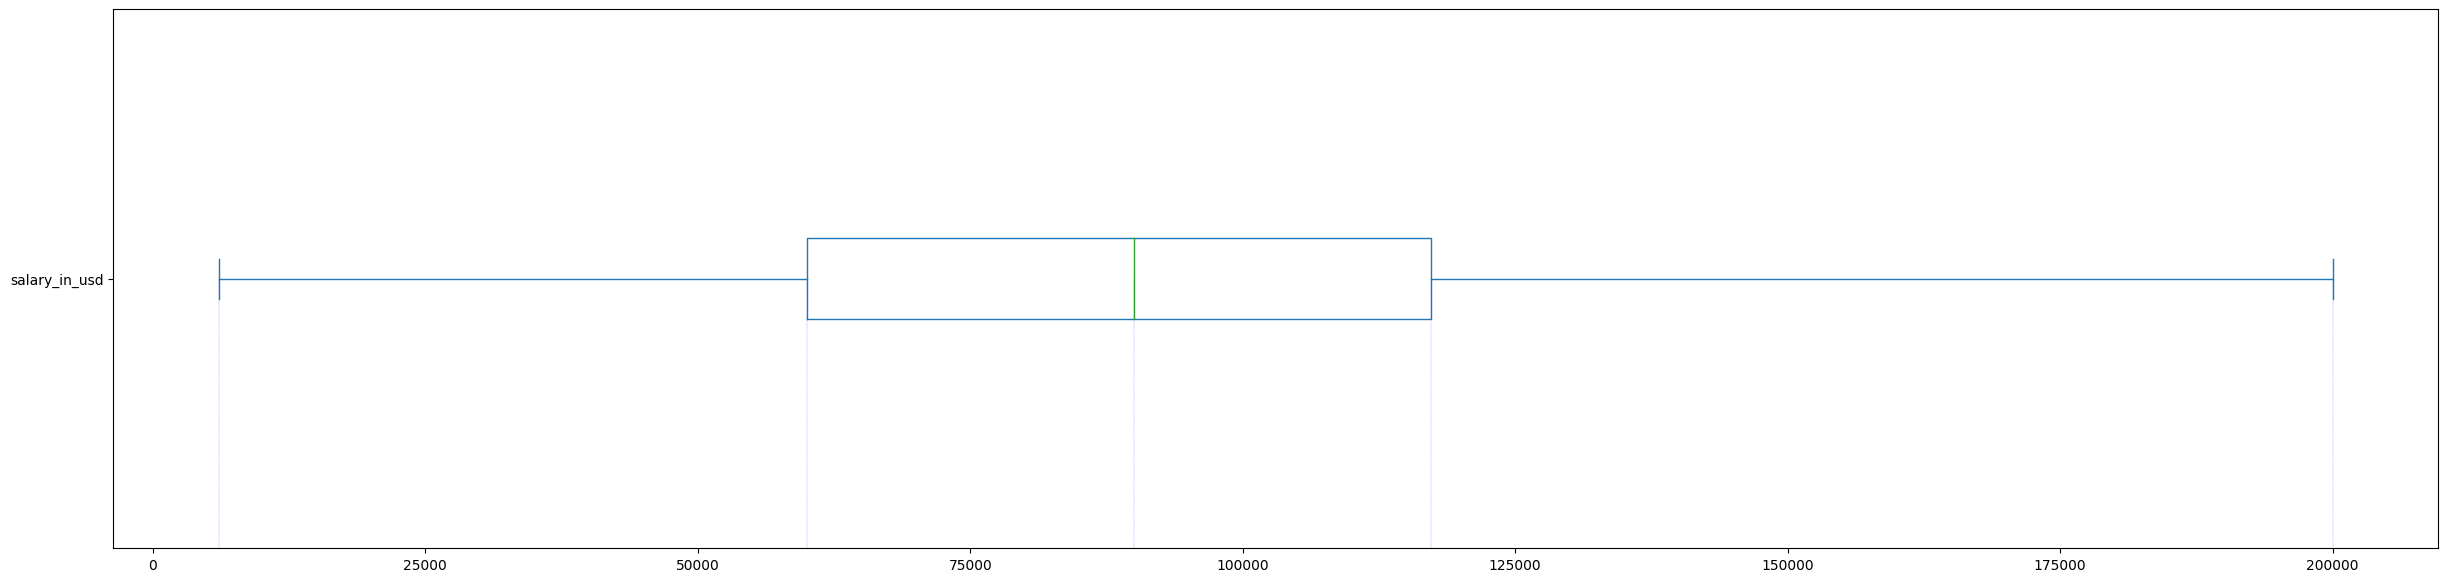

In [17]:
var = df[df["job_title"] == "Data Analyst"]
ax = var["salary_in_usd"].plot(kind="box", figsize=[30,7], vert=False, manage_ticks=True)

items = [0.00, 0.25, 0.50, 0.75, 1.00]
quantiles = np.quantile(var["salary_in_usd"], np.array(items))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.25, zorder=0)
ax.set_ylim(0.5, 1.5)

print("Cuartiles")
for pair in zip(items, quantiles):
    print(pair[0], "\t", pair[1])

plt.show()

Si se deja de considerar a Estados Unidos el rango salarial decrementa considerablemente a 32974.0 - 64232.75,  es interesante porque el máximo de este rango es más o menos, donde estaría cuando se incluye a Estados Unidos en el análisis.

Cuartiles
0.0 	 6072.0
0.25 	 32974.0
0.5 	 49139.0
0.75 	 64232.75
1.0 	 130000.0


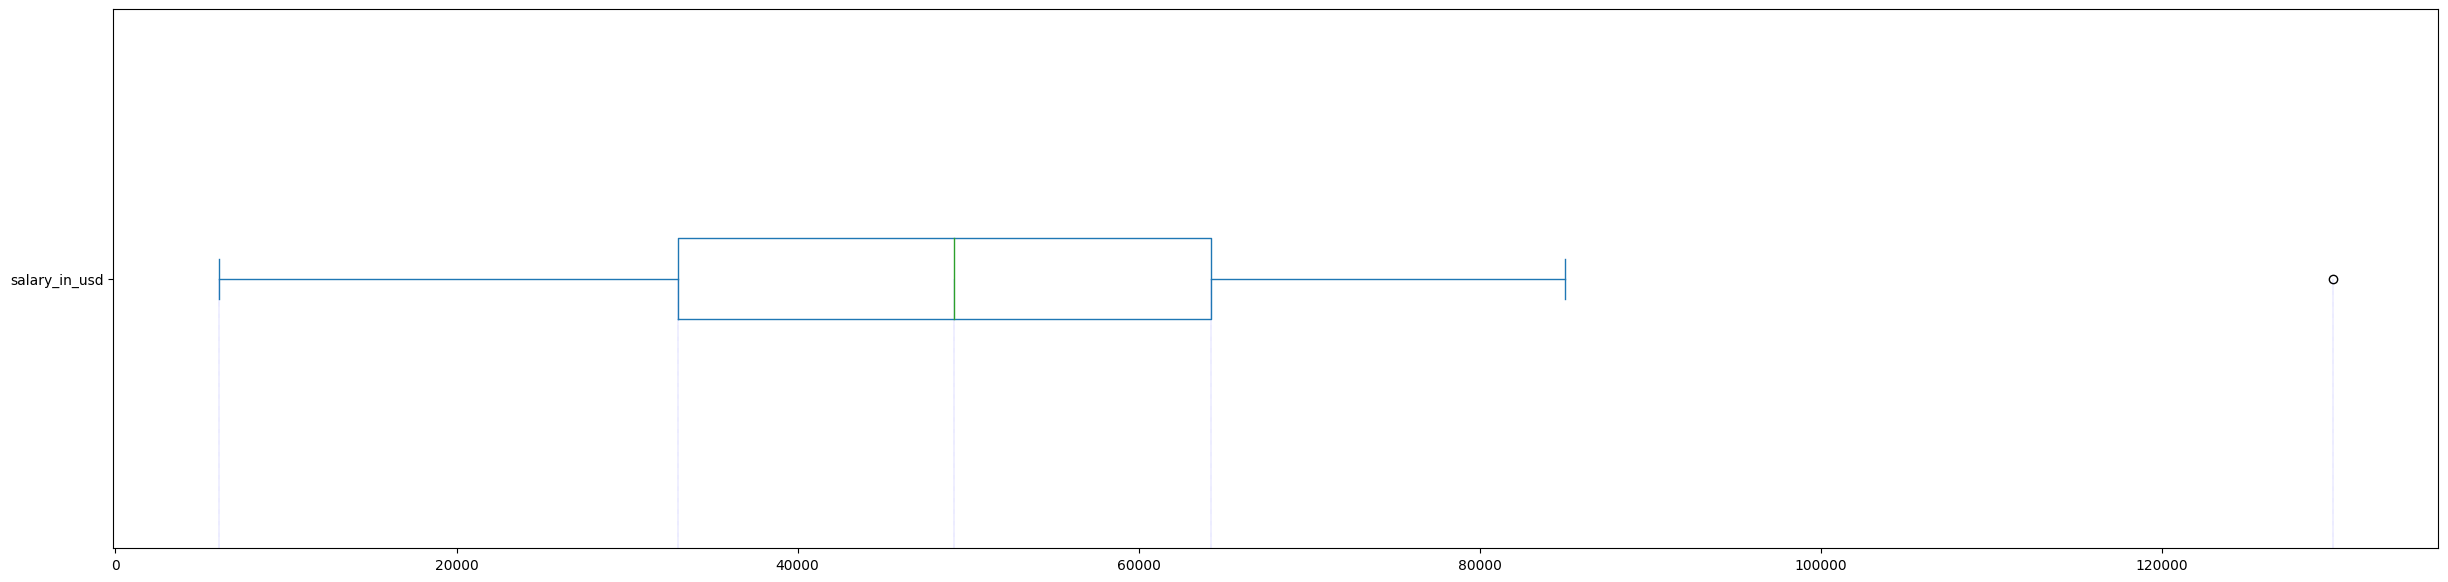

In [18]:
var = df[(df["job_title"] == "Data Analyst")  & (df["company_location"]!="US")]
ax = var["salary_in_usd"].plot(kind="box", figsize=[30,7], vert=False, manage_ticks=True)

items = [0.00, 0.25, 0.50, 0.75, 1.00]
quantiles = np.quantile(var["salary_in_usd"], np.array(items))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.25, zorder=0)
ax.set_ylim(0.5, 1.5)

print("Cuartiles")
for pair in zip(items, quantiles):
    print(pair[0], "\t", pair[1])

plt.show()

### ¿En qué países se ofrecen mejores salarios?

Lo curioso es que si bien los rangos salarios del conjunto de datos en completo se ven como se respondió en la pregunta anterior, al separar el salario en ubicaciones se puede ver que realmente esos ingresos están siendo levantados por Estados Unidos. Si tomamos la media como el salario para sacar el Top 3 , los mejores salarios estarían siendo ofrecidos en US, CA, y DE.

<AxesSubplot:>

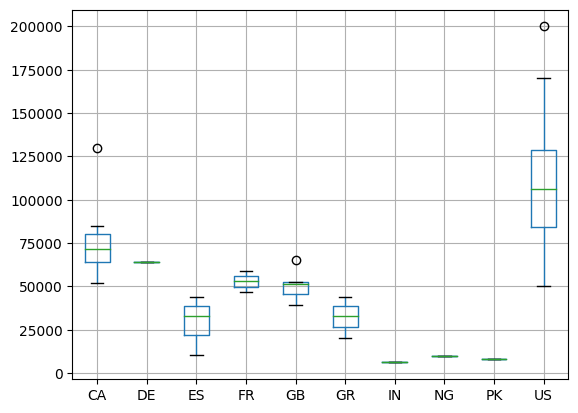

In [19]:
var = df[df["job_title"] == "Data Analyst"]
var[["company_location", "salary_in_usd"]].pivot(columns = "company_location", values="salary_in_usd").boxplot()

In [20]:
var["company_location"].value_counts()

US    56
CA     7
GB     5
ES     3
GR     3
FR     2
PK     1
NG     1
IN     1
DE     1
Name: company_location, dtype: int64

Esto es interesante conocer... la data está poco balanceada 

Dado a que el objetivo en breve es ver que afecta el salario y company location es categórica se decidió ver que impacto tienen sus grupos en el salrio

In [21]:
F, p = f_oneway(var[var.company_location=='CA'].salary_in_usd_yeojohnson,
                      var[var.company_location=='DE'].salary_in_usd_yeojohnson,
                      var[var.company_location=='ES'].salary_in_usd_yeojohnson,
                      var[var.company_location=='FR'].salary_in_usd_yeojohnson,
                      var[var.company_location=='GB'].salary_in_usd_yeojohnson,
                      var[var.company_location=='GR'].salary_in_usd_yeojohnson,
                      var[var.company_location=='IN'].salary_in_usd_yeojohnson,                
                      var[var.company_location=='NG'].salary_in_usd_yeojohnson,    
                      var[var.company_location=='PK'].salary_in_usd_yeojohnson,                                        
                      var[var.company_location=='US'].salary_in_usd_yeojohnson)
print(F, p, "significant" if p<0.05 else "not that significant")

12.048172601761559 3.02012012993668e-11 significant


Todavía falta verificar que se cumplan las "assumptions" de la prueba, pero por lo rponto sabemos que la diferencia entre grupos es significativa (estadísticamente)

In [22]:
model = ols("salary_in_usd_yeojohnson ~ C(company_location)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(company_location),0.340278,9.0,0.037809,12.048173,3.020120e-11,0.607697,0.554153
Residual,0.219669,70.0,0.003138,NaN,NaN,NaN,NaN


Nuestro equivalente al R2 (eta sq), pero omega_sq es más unbiased por lo que el efecto es de .55

In [23]:
S, p  = shapiro(model.resid)
print(S, p, "significant" if p<0.05 else "not that significant")

0.9883302450180054 0.6865758895874023 not that significant


Shapiro es non significant por lo que los residuos del modelo se distribuyen normalmente, por lo que podemos confiar en el análisis

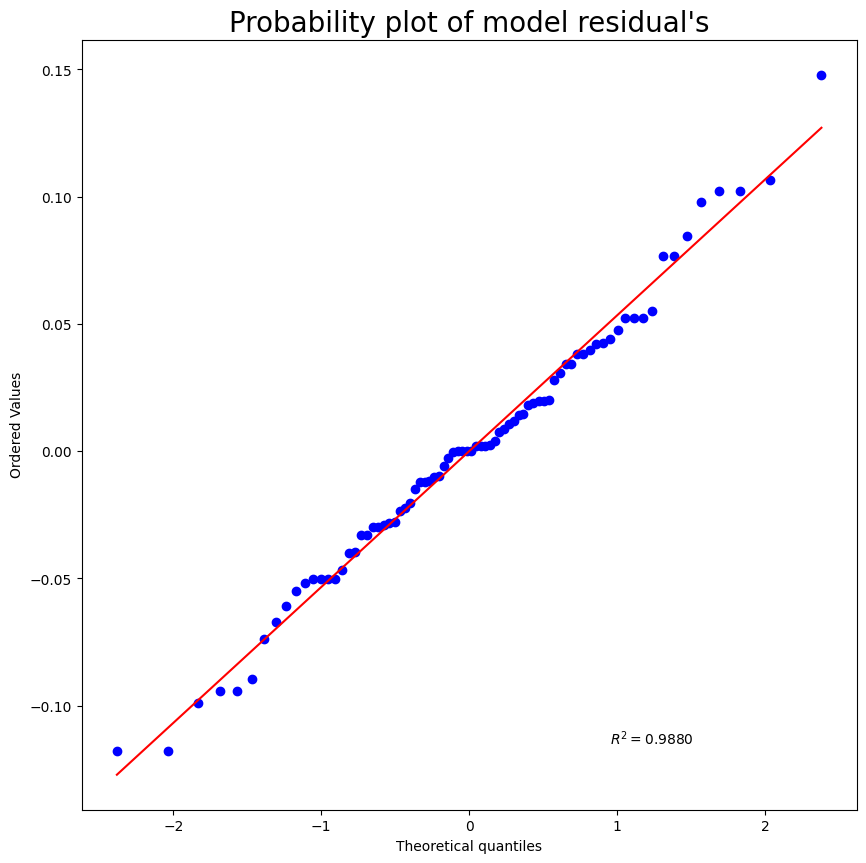

In [24]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

Para confiar bien en nuestro modelo de anova sería revisar la homegeneidad de la varianza entre los grupos

In [25]:
L, p = levene(var[var.company_location=='CA'].salary_in_usd_yeojohnson,
                      var[var.company_location=='DE'].salary_in_usd_yeojohnson,
                      var[var.company_location=='ES'].salary_in_usd_yeojohnson,
                      var[var.company_location=='FR'].salary_in_usd_yeojohnson,
                      var[var.company_location=='GB'].salary_in_usd_yeojohnson,
                      var[var.company_location=='GR'].salary_in_usd_yeojohnson,
                      var[var.company_location=='IN'].salary_in_usd_yeojohnson,                
                      var[var.company_location=='NG'].salary_in_usd_yeojohnson,    
                      var[var.company_location=='PK'].salary_in_usd_yeojohnson,                                        
                      var[var.company_location=='US'].salary_in_usd_yeojohnson)
print(L, p, "significant" if p<0.05 else "not that significant")

1.5507884353972694 0.14758550567620657 not that significant


La prueba indica al (ser no significativa) se indicaría que la diferencia de varianza entre los grupos no es significativa, lo que hace match con lo visto en el boxplot.

Pero, ¿Qué países son más diferentes entre sí?

In [26]:
comp = mc.MultiComparison(var['salary_in_usd_yeojohnson'], var['company_location'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
CA,DE,-0.0273,1.0,-0.223,0.1684,False
CA,ES,-0.1144,0.1088,-0.2408,0.0119,False
CA,FR,-0.0529,0.9735,-0.1996,0.0939,False
CA,GB,-0.058,0.752,-0.1652,0.0492,False
CA,GR,-0.1051,0.1865,-0.2314,0.0212,False
CA,IN,-0.179,0.1016,-0.3747,0.0167,False
CA,NG,-0.1671,0.1599,-0.3628,0.0286,False
CA,PK,-0.1731,0.1278,-0.3688,0.0226,False
CA,US,0.0581,0.2441,-0.0153,0.1315,False
DE,ES,-0.0871,0.9387,-0.2985,0.1243,False


/tmp/ipykernel_3429/534653529.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Country", xlabel= "Score Difference", ).show()


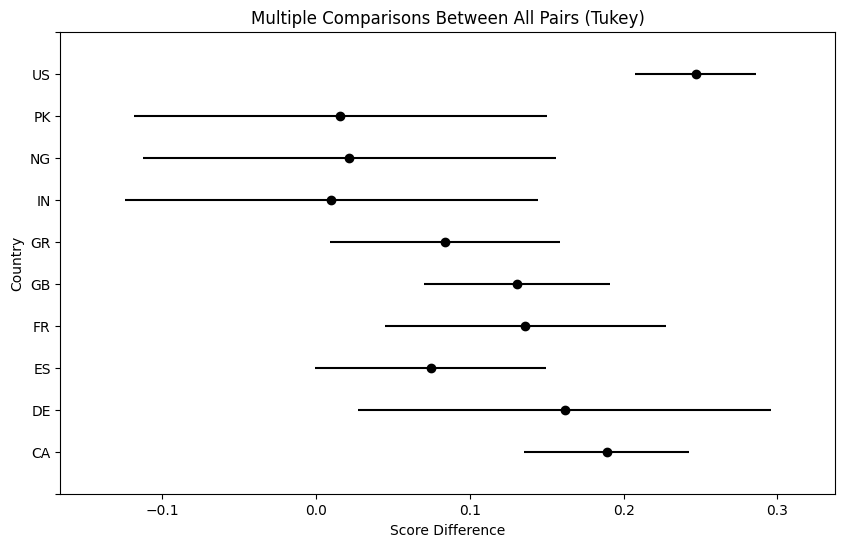

In [27]:
post_hoc_res.plot_simultaneous(ylabel= "Country", xlabel= "Score Difference", ).show()

Dentro de lo observado el país más diferente sería Estados Unidos, lo que hace sentido cuando vimos el rango salarial

### ¿Se han incrementado los salarios a lo largo del tiempo?

/home/repos/mysql/school/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:>

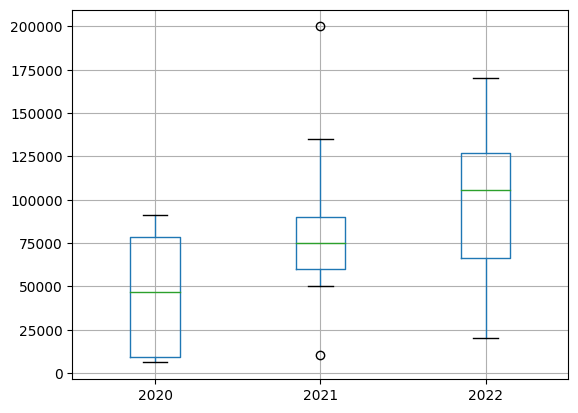

In [28]:
var = df[df["job_title"] == "Data Analyst"]

var[["work_year", "salary_in_usd"]].pivot(columns = "work_year", values="salary_in_usd").boxplot()

In [29]:
var["work_year"].value_counts()

2022    56
2021    17
2020     7
Name: work_year, dtype: int64

la data está poco balanceada pero interesante de conocer ... me gustaría ver esta distribución por país

Visualmente han incremenatado los salarios conforme ha pasado el tiempo..., pero si repetimos un análisis de ANOVA podríamos responder con certitud si han aumentado.

In [30]:
F, p = f_oneway(var[var.work_year==2020].salary_in_usd_yeojohnson,
                      var[var.work_year==2021].salary_in_usd_yeojohnson,
                      var[var.work_year==2022].salary_in_usd_yeojohnson)
print(F, p, "significant" if p<0.05 else "not that significant")

7.830143468536169 0.0008025789243893507 significant


Estadísticamente podemos ver primero que hay una diferencia significativa entre los años y su efecto en el salario

In [31]:
model = ols("salary_in_usd_yeojohnson ~ C(work_year)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(work_year),0.094635,2.0,0.047318,7.830143,0.000803,0.169008,0.145849
Residual,0.465312,77.0,0.006043,NaN,NaN,NaN,NaN


Nuestro equivalente al R2 (eta sq), pero omega_sq es más unbiased por lo que el efecto es de .14

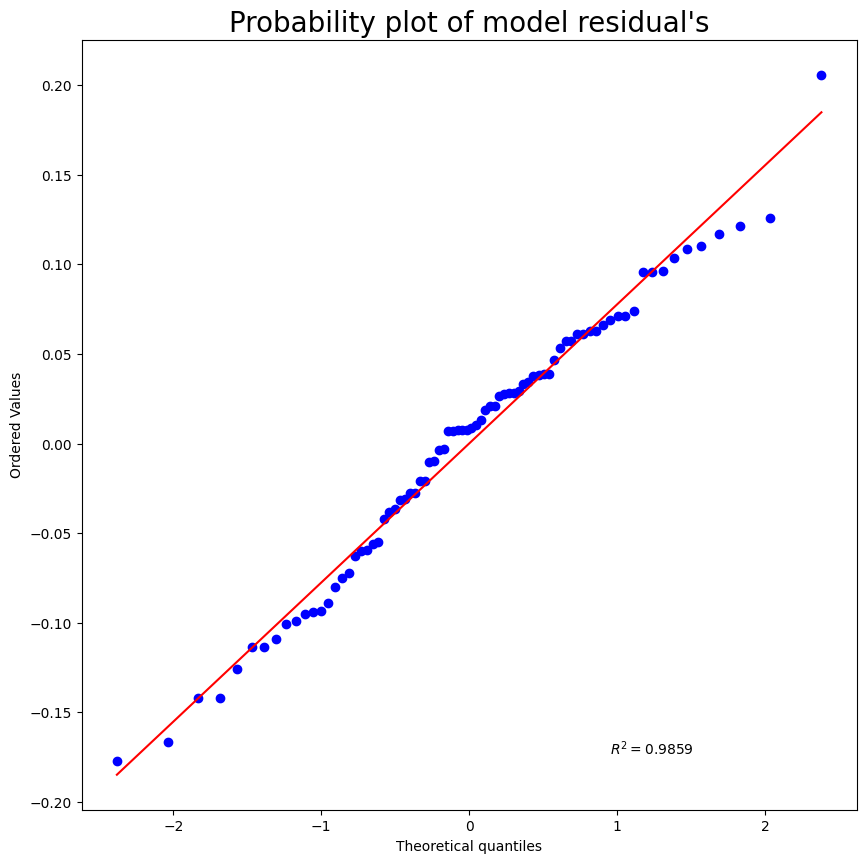

In [32]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

Assumption 1 =  CHECK = Los residuales del modelo se distribuyen normalmente

In [33]:
L, p = levene(var[var.work_year==2020].salary_in_usd_yeojohnson,
                  var[var.work_year==2021].salary_in_usd_yeojohnson,
                  var[var.work_year==2022].salary_in_usd_yeojohnson)
print(L, p, "significant" if p<0.05 else "not that significant")

0.8919168373924319 0.4140608622374484 not that significant


La prueba indica al (ser no significativa) se indicaría que la diferencia de varianza entre los grupos no es significativa, lo que indicaría que no hay diferencia significativa en su varianza.

In [34]:
comp = mc.MultiComparison(var['salary_in_usd_yeojohnson'], var['work_year'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


group1,group2,meandiff,p-adj,lower,upper,reject
2020,2021,0.0784,0.0697,-0.005,0.1619,False
2020,2022,0.1173,0.0009,0.0429,0.1918,True
2021,2022,0.0389,0.1741,-0.0125,0.0903,False


/tmp/ipykernel_3429/2291410289.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Years", xlabel= "Score Difference", ).show()


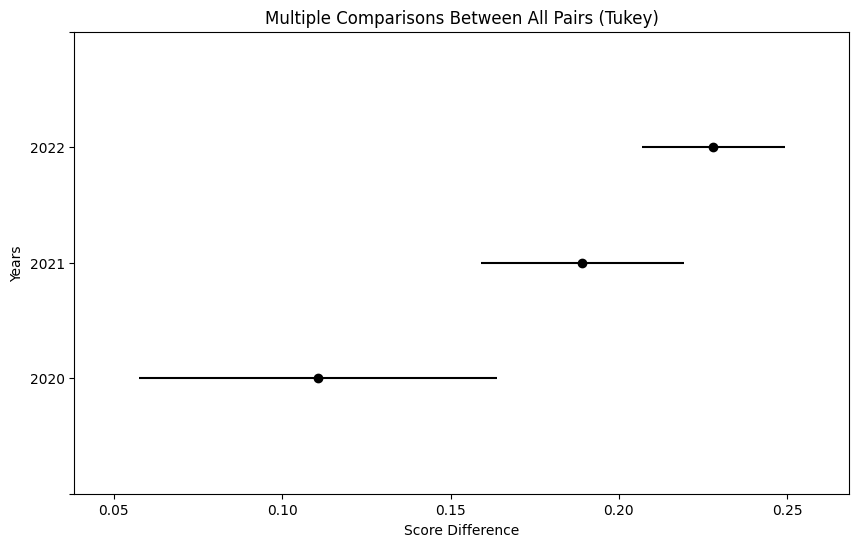

In [35]:
post_hoc_res.plot_simultaneous(ylabel= "Years", xlabel= "Score Difference", ).show()

Ya se veía que han crecido o bueno que había diferencia entre ellos, es decir el salario había aumentado, pero con este análisis veo que han crecido suficiente. 

### ¿Influye el nivel de experiencia en el salario?

<AxesSubplot:>

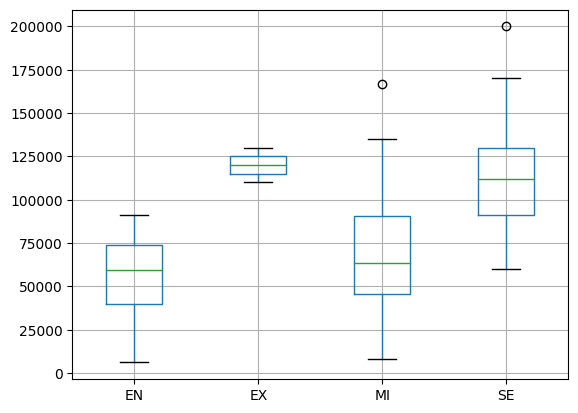

In [36]:
var = df[df["job_title"] == "Data Analyst"]

var[["experience_level", "salary_in_usd"]].pivot(columns = "experience_level", values="salary_in_usd").boxplot()

In [37]:
var["experience_level"].value_counts()

SE    38
MI    28
EN    12
EX     2
Name: experience_level, dtype: int64

In [38]:
F, p = f_oneway(var[var.experience_level=='MI'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='SE'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='EN'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='EX'].salary_in_usd_yeojohnson)
print(F, p, "significant" if p<0.05 else "not that significant")

14.01617090001817 2.3163119459928548e-07 significant


De acuerdo a esto la diferencia entre los niveles de experiencia y su efecto en el salario es  significativa

In [39]:
model = ols("salary_in_usd_yeojohnson ~ C(experience_level)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(experience_level),0.199451,3.0,0.066484,14.016171,2.316312e-07,0.356197,0.328005
Residual,0.360496,76.0,0.004743,NaN,NaN,NaN,NaN


Tiene un omega interesante que es mejor que el del work year

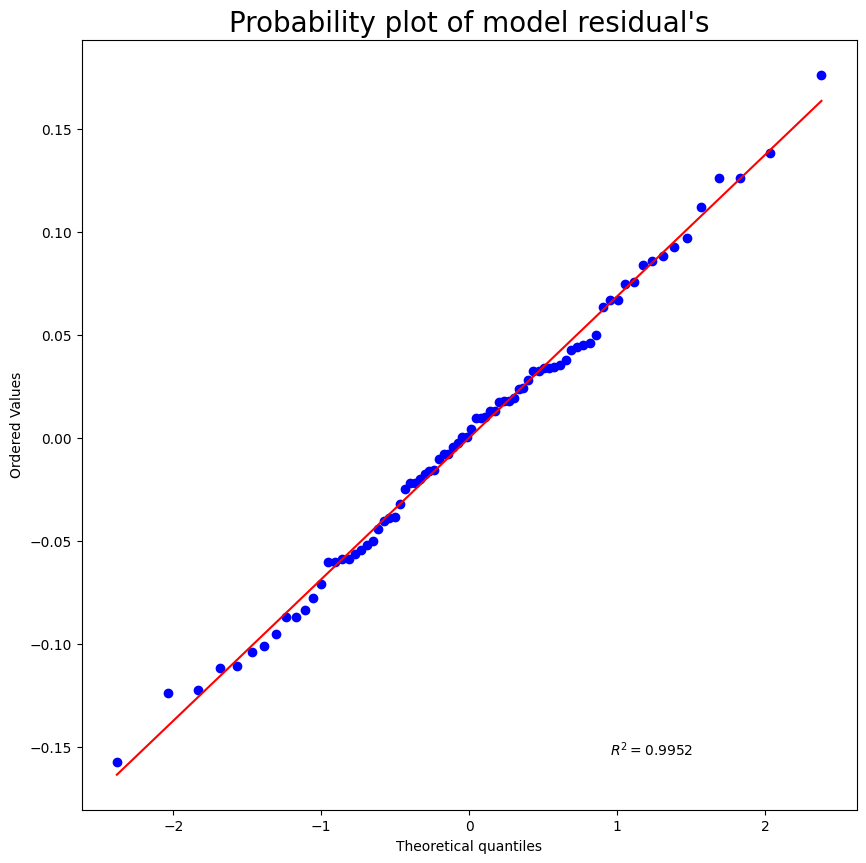

In [40]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [41]:
L, p = levene(var[var.experience_level=='MI'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='SE'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='EN'].salary_in_usd_yeojohnson,
                      var[var.experience_level=='EX'].salary_in_usd_yeojohnson)
print(L, p, "significant" if p<0.05 else "not that significant")

1.6982866972159651 0.17449350690764961 not that significant


Nuetro modelo de anova cumple con la normalidad de los residuales y con que haya homogeneidad de varianza entre los grupos.

In [42]:
comp = mc.MultiComparison(var['salary_in_usd_yeojohnson'], var['experience_level'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
EN,EX,0.1398,0.0463,0.0016,0.278,True
EN,MI,0.0396,0.3478,-0.0228,0.102,False
EN,SE,0.1233,0.0,0.0634,0.1832,True
EX,MI,-0.1002,0.2018,-0.2326,0.0322,False
EX,SE,-0.0165,0.9874,-0.1478,0.1147,False
MI,SE,0.0837,0.0,0.0386,0.1287,True


/tmp/ipykernel_3429/2447143203.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Experience", xlabel= "Score Difference", ).show()


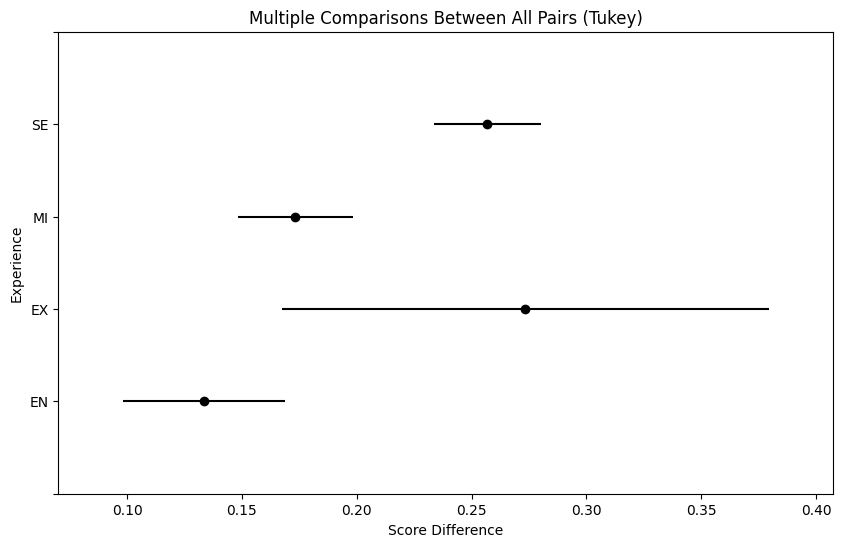

In [43]:
post_hoc_res.plot_simultaneous(ylabel= "Experience", xlabel= "Score Difference", ).show()

De lo que puedo observar aquí esta variable si presenta cambios al influir en el salario y de manera bastante significativa

### ¿Influye el tamaño de la compañía en el salario que puede ofrecer a un analista de datos?

<AxesSubplot:>

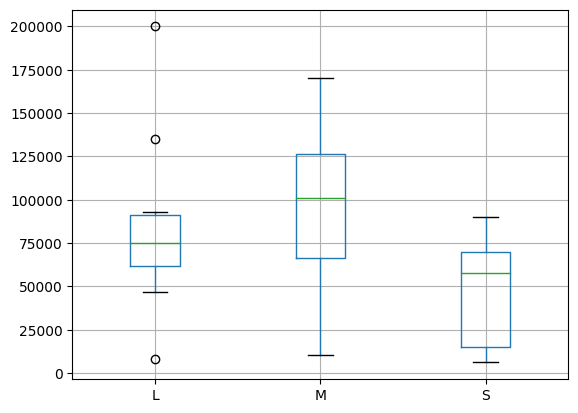

In [44]:
var = df[df["job_title"] == "Data Analyst"]

var[["company_size", "salary_in_usd"]].pivot(columns = "company_size", values="salary_in_usd").boxplot()

In [45]:
var["company_size"].value_counts()

M    60
L    13
S     7
Name: company_size, dtype: int64

In [46]:
F, p = f_oneway(var[var.company_size=='S'].salary_in_usd_yeojohnson,
                      var[var.company_size=='M'].salary_in_usd_yeojohnson,
                      var[var.company_size=='L'].salary_in_usd_yeojohnson)
print(F, p, "significant" if p<0.05 else "not that significant")

6.544403042511147 0.002371733620694143 significant


La diferencia entre los tamaños de la compañía y sus efectos sobre el salario indican ser significativos

In [47]:
model = ols("salary_in_usd_yeojohnson ~ C(company_size)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(company_size),0.081354,2.0,0.040677,6.544403,0.002372,0.145288,0.121736
Residual,0.478594,77.0,0.006216,NaN,NaN,NaN,NaN


Hasta donde va el análisis el omega sq más bajo que hemos visto.

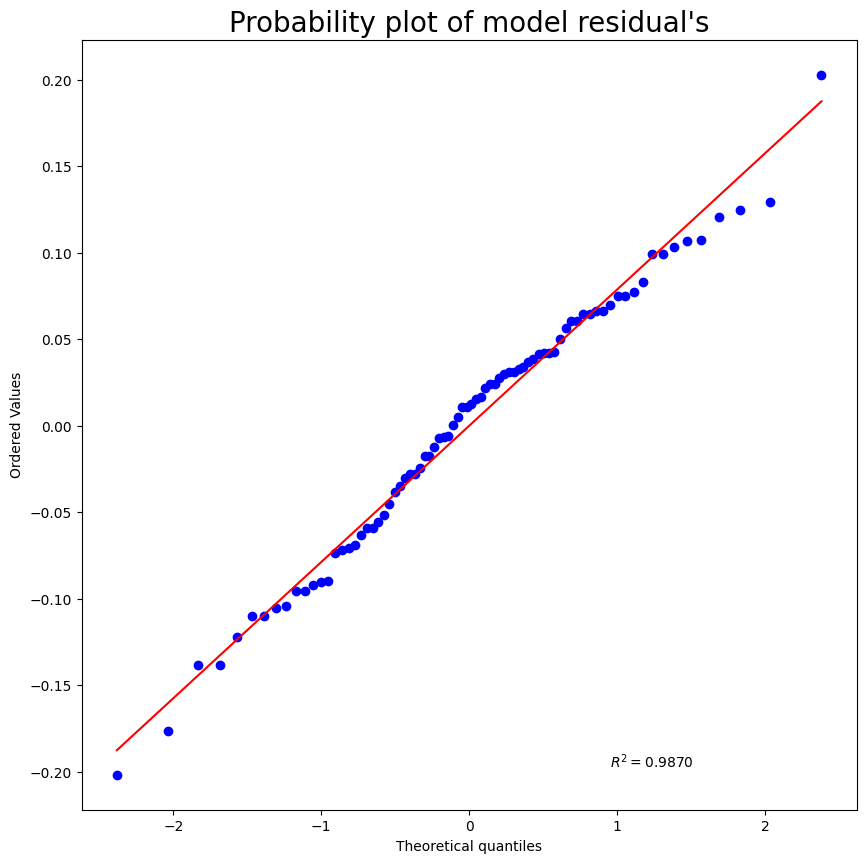

In [48]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [49]:
L, p = levene(var[var.company_size=='S'].salary_in_usd_yeojohnson,
                      var[var.company_size=='M'].salary_in_usd_yeojohnson,
                      var[var.company_size=='L'].salary_in_usd_yeojohnson)
print(L, p, "significant" if p<0.05 else "not that significant")

0.09135185797007643 0.9127952808877393 not that significant


Cumple con homogeneidad y normalidad, anova es usable

In [50]:
comp = mc.MultiComparison(var['salary_in_usd_yeojohnson'], var['company_size'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
L,M,0.0325,0.3739,-0.0252,0.0901,False
L,S,-0.078,0.0941,-0.1664,0.0103,False
M,S,-0.1105,0.0021,-0.1858,-0.0353,True


/tmp/ipykernel_3429/1212985479.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Size", xlabel= "Score Difference", ).show()


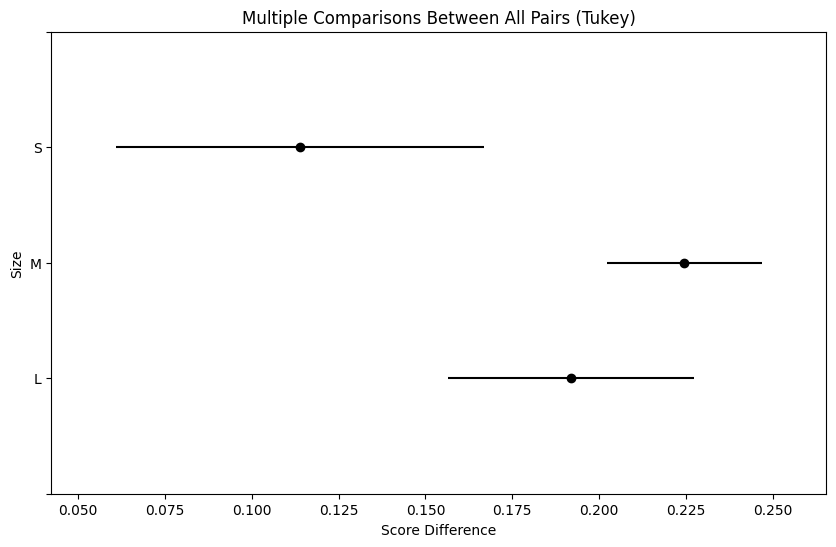

In [51]:
post_hoc_res.plot_simultaneous(ylabel= "Size", xlabel= "Score Difference", ).show()

Esta variable podría meter la suficiente diferencia para que el modelo mejore(de hecho si impacta por unos decimales en el modelo)

### ¿Qué tipo de contrato (parcial, tiempo completo, etc) ofrece mejores salarios? ¿Qué tipo de contrato será el más conveniente?

Para un analista de datos de acuerdo a un análisis rápido sería de full

<AxesSubplot:>

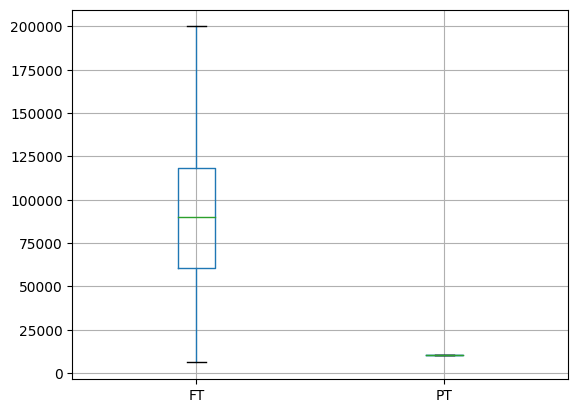

In [52]:
var = df[df["job_title"] == "Data Analyst"]
var[["employment_type", "salary_in_usd"]].pivot(columns = "employment_type", values="salary_in_usd").boxplot()

In [53]:
var["employment_type"].value_counts()

FT    79
PT     1
Name: employment_type, dtype: int64

Definitivamente esta variable en mi opinión no presenta un apoyo considerable desde que en los analistas de datos solo FT tiene buenas muestras

In [54]:
F, p = f_oneway(var[var.employment_type=='FT'].salary_in_usd_yeojohnson,
                    var[var.employment_type=='PT'].salary_in_usd_yeojohnson)
print(F, p, "significant" if p<0.05 else "not that significant")

5.248667089031851 0.024663819720091632 significant


El efecto de los grupos de tipo de empleo tiene una diferencia significativa 

In [55]:
model = ols("salary_in_usd_yeojohnson ~ C(employment_type)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(employment_type),0.035304,1.0,0.035304,5.248667,0.024664,0.063048,0.05043
Residual,0.524644,78.0,0.006726,NaN,NaN,NaN,NaN


Esta variable es definitva una que no pondría en el modelo, ya que para empezar

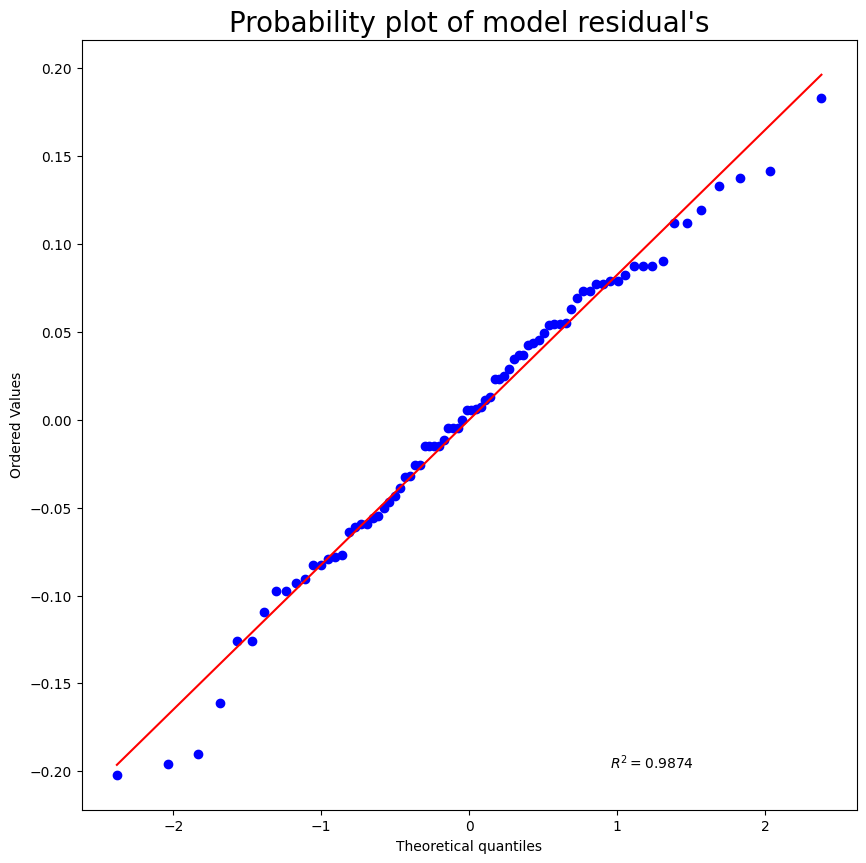

In [56]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [57]:
L, p = levene(var[var.employment_type=='FT'].salary_in_usd_yeojohnson,
                    var[var.employment_type=='PT'].salary_in_usd_yeojohnson)
print(L, p, "significant" if p<0.05 else "not that significant")

1.8655533862447742 0.17591074715140673 not that significant


El modelo de anova tiene homogeneidad y normalidad cumplidas

In [58]:
comp = mc.MultiComparison(var['salary_in_usd_yeojohnson'], var['employment_type'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FT,PT,-0.1891,0.0247,-0.3534,-0.0248,True


/tmp/ipykernel_3429/3345537802.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Employment", xlabel= "Score Difference", ).show()


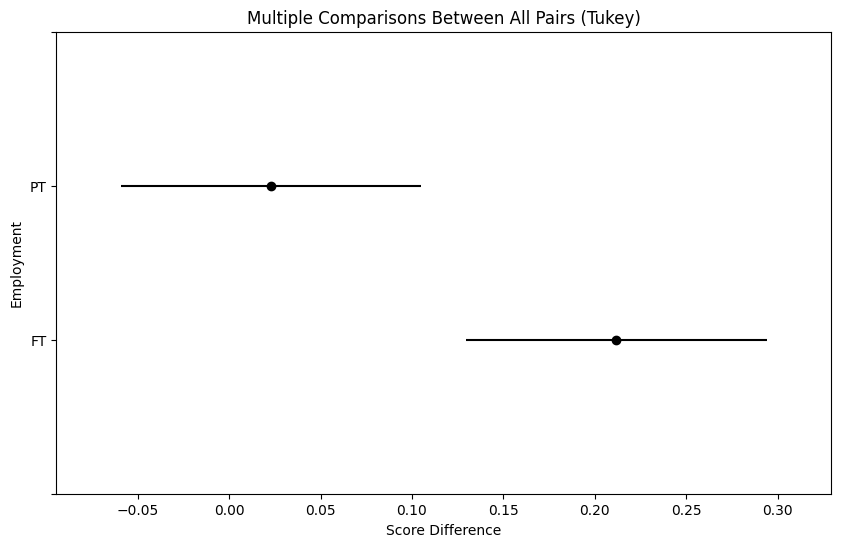

In [59]:
post_hoc_res.plot_simultaneous(ylabel= "Employment", xlabel= "Score Difference", ).show()

Si bien hay distancia por la cantidad de elementos en el PT no me confiaría

## One Way Test

Aquí resumimos los resultados obtenidos arriba

In [60]:
var = df[df["job_title"] == "Data Analyst"]
oneway_all_columns(var.drop(columns="job_title"), "salary_in_usd_yeojohnson")

,column,F,P-value,Statistically significant (pval < 05)
0,company_location,12.048173,3.020120e-11,True
1,work_year,7.830143,8.025789e-04,True
2,experience_level,14.016171,2.316312e-07,True
3,company_size,6.544403,2.371734e-03,True
4,employment_type,5.248667,2.466382e-02,True


Concluyendo nuestro análisis todas impactan en el modelo... pero hay ciertas condiciones que vulven ciertas variables poco interesantes para resolver la preguna de que condiciones son las que darían un mejor salario. Entre ellas es la que más rápidamente descartamos que es el employment type por estar poco balanceada y con esto partimos al proceso de generar un modelo que minizaremos y optimizaremos para encontrar la combinación que genera un mejor salario y un peor salario. Pero todo esto es viendo como interactuan individualmente cada una con el salario falta ver como impactan en conjunto

# STEPWISE

In [61]:
var = df[df["job_title"] == "Data Analyst"]

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes

stepwise_selection(var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"] )

Add  experience_level               with p-value 1.99236e-06
Add  company_location               with p-value 5.20125e-05


['experience_level', 'company_location']

## All Variables Model

Aquí vamos a explorar como interactuán todas las variables en conjunto y su impacto en el modelo.

In [62]:
var = df[df["job_title"] == "Data Analyst"]

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes

formula = 'salary_in_usd_yeojohnson ~ work_year + C(company_location) +  C(experience_level) +  C(company_size) +  C(employment_type)   ' # formula 
                                  
model = ols(formula, var).fit()
print(model.summary())
print(anova_lm(model))

                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.711
Model:                                  OLS   Adj. R-squared:                  0.637
Method:                       Least Squares   F-statistic:                     9.670
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):           1.52e-11
Time:                              21:50:56   Log-Likelihood:                 134.57
No. Observations:                        80   AIC:                            -235.1
Df Residuals:                            63   BIC:                            -194.6
Df Model:                                16                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

Este modelo considera todas las variables, incluyendo la que no nos gusta tanto de employment type.

In [63]:
anova_table(anova_lm(model, typ=2)).sort_values(by="omega_sq", ascending=False)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(company_location),0.140534,9.0,0.015615,6.071414,0.000004,0.426293,0.353324
C(experience_level),0.013232,3.0,0.004411,1.714961,0.172949,0.040138,0.016604
C(company_size),0.010101,2.0,0.005050,1.963676,0.148838,0.030639,0.014920
work_year,0.003054,1.0,0.003054,1.187283,0.280029,0.009263,0.001450
C(employment_type),0.000717,1.0,0.000717,0.278801,0.599343,0.002175,-0.005583
Residual,0.162028,63.0,0.002572,NaN,NaN,NaN,NaN


Todavía ocuparíamos validar este modelo pero aquí podemos ir viendo como ya sospechabamos que no nos convendría considerar el employment type, pero que sería bueno contar con company_location

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


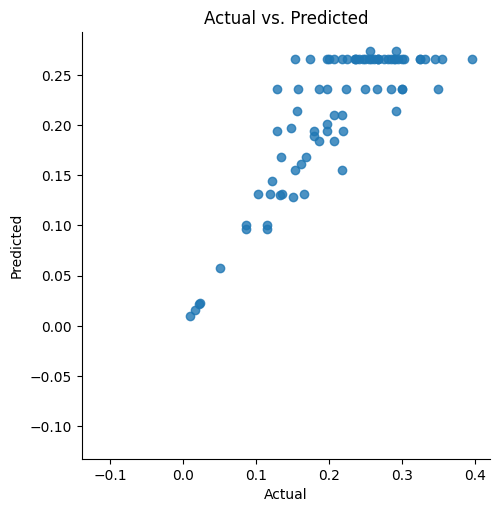

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0488501509845217
Residuals are not normally distributed


/tmp/ipykernel_3429/2009388479.py:173: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


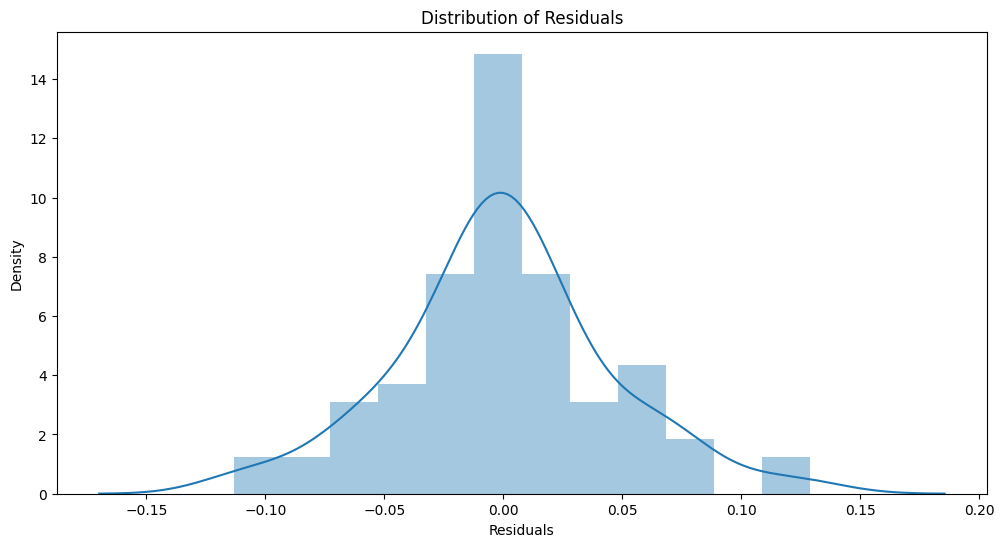


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


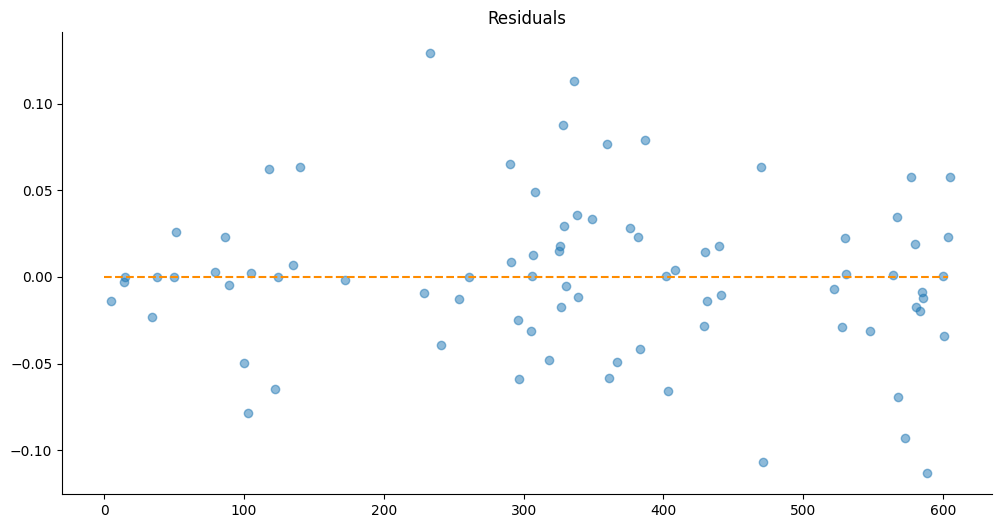

Assumption 3: Little to no multicollinearity among predictors


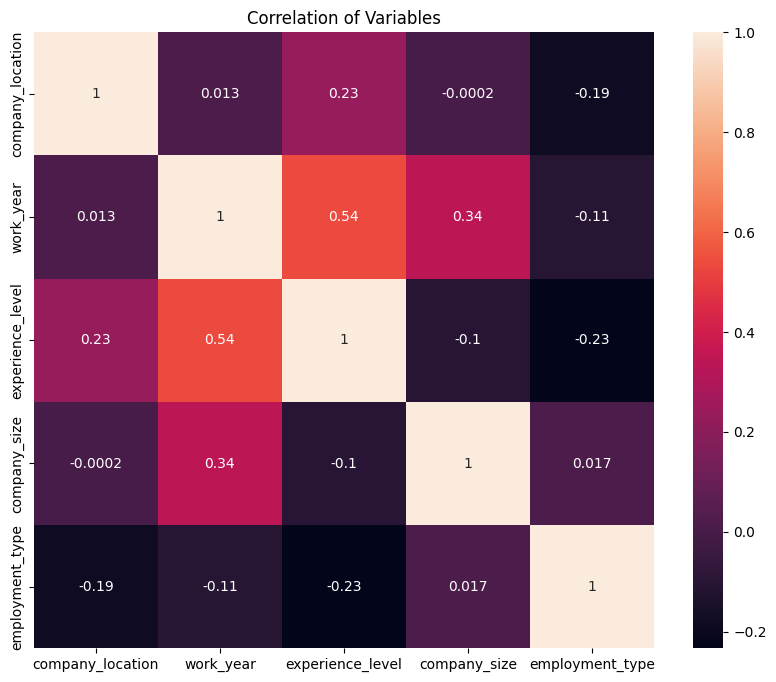

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
company_location: 0.007142601712299363
work_year: -0.7790369301684255
experience_level: -1.1104013240126989
company_size: 5.2556016244207076
employment_type: 1.0351245909793332

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.1174760646251505
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


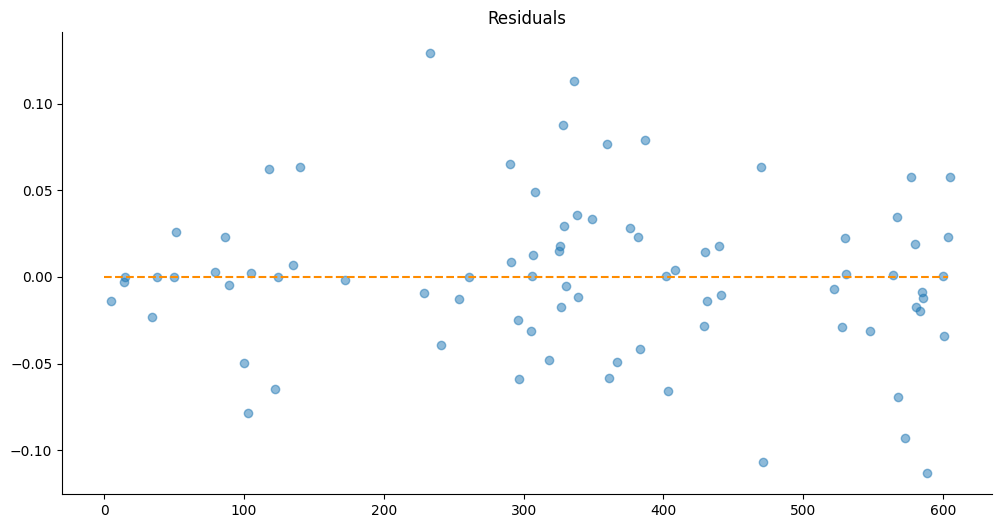

In [64]:
linear_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"])
normal_errors_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"])
multicollinearity_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"], ["company_location", "work_year", "experience_level", "company_size", "employment_type"])
autocorrelation_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "work_year", "experience_level", "company_size", "employment_type"]], var["salary_in_usd_yeojohnson"])

Pues en esencia no es tan modelo y abre puerta a ciertas mejoras.

In [65]:
var = df[df["job_title"] == "Data Analyst"]

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col+"_cat"] = var[col].cat.codes

print("ENCODING")
for col1, col2 in zip(["company_location", "work_year", "experience_level", "company_size", "employment_type"],[ "company_location_cat", "work_year_cat", "experience_level_cat", "company_size_cat", "employment_type_cat"]):
    print(col1, "  ", list(zip(var[col1].unique(), var[col2].unique())))

ENCODING
company_location    [('US', 9), ('PK', 8), ('FR', 3), ('NG', 7), ('IN', 6), ('GB', 4), ('ES', 2), ('CA', 0), ('DE', 1), ('GR', 5)]
work_year    [(2020, 0), (2021, 1), (2022, 2)]
experience_level    [('EN', 0), ('MI', 2), ('SE', 3), ('EX', 1)]
company_size    [('L', 0), ('S', 2), ('M', 1)]
employment_type    [('FT', 0), ('PT', 1)]


In [66]:
model.params.sort_values(ascending=False)

Intercept                   0.141976
C(experience_level)[T.1]    0.053778
C(company_location)[T.9]    0.051721
C(experience_level)[T.3]    0.046468
work_year                   0.025702
C(experience_level)[T.2]    0.016569
C(company_location)[T.3]   -0.014366
C(company_size)[T.1]       -0.025492
C(employment_type)[T.1]    -0.035204
C(company_location)[T.1]   -0.052594
C(company_location)[T.4]   -0.053562
C(company_location)[T.7]   -0.055693
C(company_size)[T.2]       -0.064554
C(company_location)[T.6]   -0.067537
C(company_location)[T.2]   -0.084198
C(company_location)[T.5]   -0.087680
C(company_location)[T.8]   -0.142815
dtype: float64

# RESPUESTA A QUE CONDICIONES MEJORAN EL SALARIO (Model based)

La ubicación que más impacta al salario positivamente es ESTADOS UNIDOS, el nivel de experiencia que mejor impacta al  salario es EX, en si el tamaño de la compañía impacta negativamente pero la que menos afecta al salario es la de tamaño MEDIANO, ahora el employment type está super biased por como está balanceado nuestro modelo... pero sería PT. Y así de una manera algo complicada resolvimos la pregunta y de paso hicimos un pequeño modelo que nos ayuda... Pero ... sin embargo veamos que otras cosas se pueden observar en los modelos.

## Model considering the best variables (top 2)

In [67]:
var = df[df["job_title"] == "Data Analyst"]
print(len(var))

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes

formula = 'salary_in_usd_yeojohnson ~ C(company_location) +  C(experience_level)' # formula                                        
model = ols(formula,var).fit()
print(model.summary())

80
                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.687
Model:                                  OLS   Adj. R-squared:                  0.631
Method:                       Least Squares   F-statistic:                     12.28
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):           1.06e-12
Time:                              21:50:58   Log-Likelihood:                 131.48
No. Observations:                        80   AIC:                            -237.0
Df Residuals:                            67   BIC:                            -206.0
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [68]:
anova_table(anova_lm(model, typ=2)).sort_values(by="omega_sq", ascending=False)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(company_location),0.185474,9.0,0.020608,7.889043,7.759484e-08,0.457799,0.397208
C(experience_level),0.044647,3.0,0.014882,5.697154,1.552374e-03,0.110201,0.090276
Residual,0.175022,67.0,0.002612,NaN,NaN,NaN,NaN


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


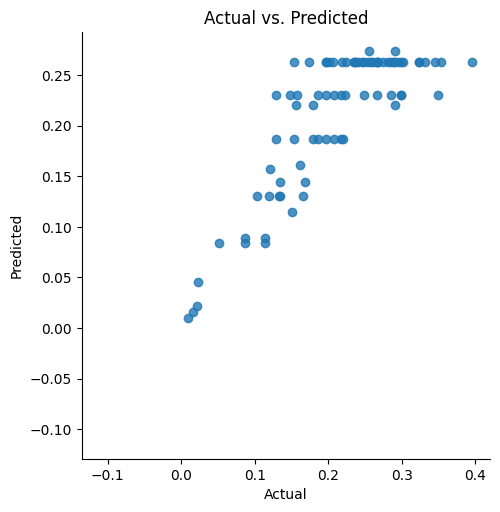

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5407211682032489
Residuals are normally distributed


/tmp/ipykernel_3429/2009388479.py:173: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


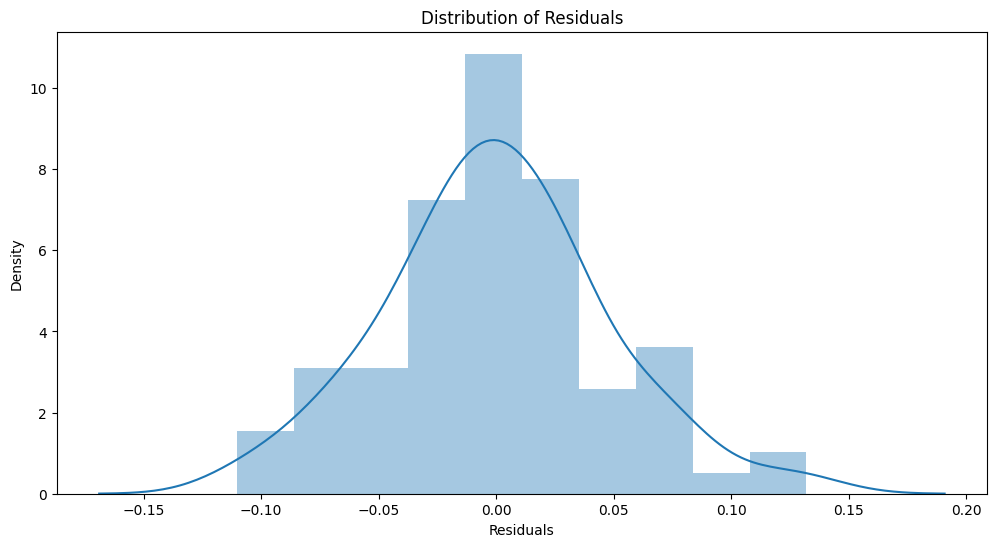


Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


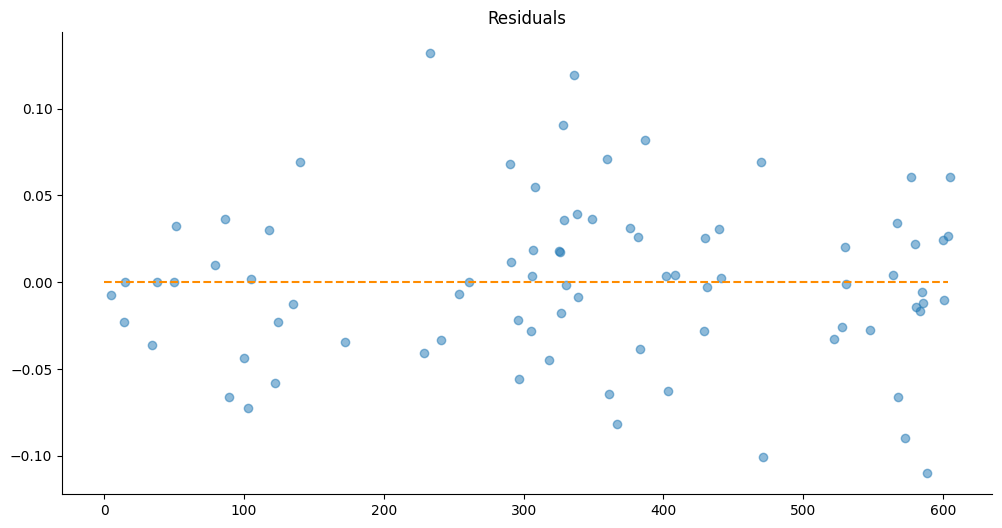

Assumption 3: Little to no multicollinearity among predictors


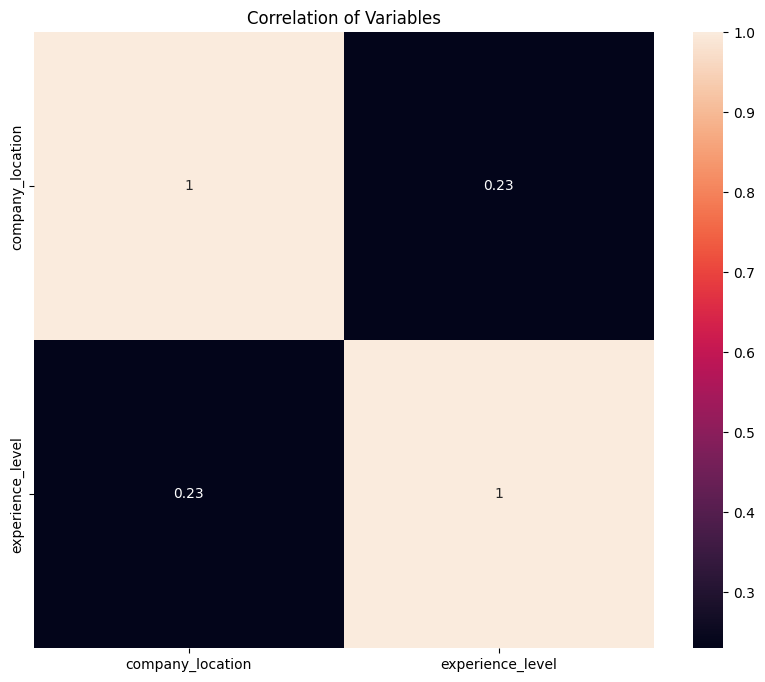

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
company_location: 0.005756589329029116
experience_level: -0.4919359056438741

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0717572326769096
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


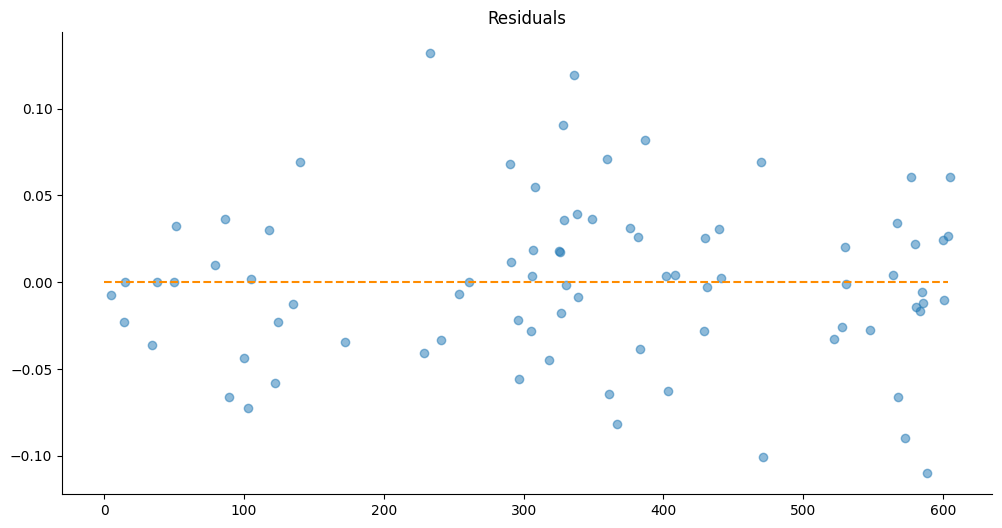

In [69]:
linear_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
normal_errors_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
multicollinearity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"], ["company_location", "experience_level"])
autocorrelation_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])

Esto modelo sigue las variables que escogió el stepwise y si es de los fuertes pero en sí no lo veo mejor que todas las variables en conjunto

## Model considering the best variables (top 3)

In [70]:
var = df[df["job_title"] == "Data Analyst"]
print(len(var))

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes

formula = 'salary_in_usd_yeojohnson ~ work_year + C(company_location) +  C(experience_level)' # formula                                        
model = ols(formula,var).fit()
print(model.summary())

80
                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.692
Model:                                  OLS   Adj. R-squared:                  0.631
Method:                       Least Squares   F-statistic:                     11.38
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):           2.56e-12
Time:                              21:50:59   Log-Likelihood:                 132.01
No. Observations:                        80   AIC:                            -236.0
Df Residuals:                            66   BIC:                            -202.7
Df Model:                                13                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Model considering the best variables (top 4)

In [71]:
var = df[df["job_title"] == "Data Analyst"]
print(len(var))

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes


formula = 'salary_in_usd_yeojohnson ~ work_year + C(company_location) +  C(experience_level) + C(company_size)' # formula                                        
model = ols(formula,var).fit()
print(model.summary())

80
                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.709
Model:                                  OLS   Adj. R-squared:                  0.641
Method:                       Least Squares   F-statistic:                     10.41
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):           5.18e-12
Time:                              21:50:59   Log-Likelihood:                 134.39
No. Observations:                        80   AIC:                            -236.8
Df Residuals:                            64   BIC:                            -198.7
Df Model:                                15                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Model Excluding the US

In [72]:
var = df[(df["job_title"] == "Data Analyst")  & (df["company_location"]!="US")]

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes


for col in ["company_location", "work_year", "experience_level", "company_size", "employment_type"]:
    print(var[col].value_counts())

0    7
4    5
2    3
5    3
3    2
8    1
7    1
6    1
1    1
Name: company_location, dtype: int64
2    15
1     5
0     4
Name: work_year, dtype: int64
1    14
0     6
2     4
Name: experience_level, dtype: int64
1    17
0     4
2     3
Name: company_size, dtype: int64
0    23
1     1
Name: employment_type, dtype: int64


In [73]:
print(len(var))
formula = 'salary_in_usd_yeojohnson ~  C(company_location) +  C(experience_level) ' # formula                                        
model = ols(formula,var).fit()
print(model.summary())

24
                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.814
Model:                                  OLS   Adj. R-squared:                  0.670
Method:                       Least Squares   F-statistic:                     5.679
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):            0.00237
Time:                              21:50:59   Log-Likelihood:                 51.510
No. Observations:                        24   AIC:                            -81.02
Df Residuals:                            13   BIC:                            -68.06
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


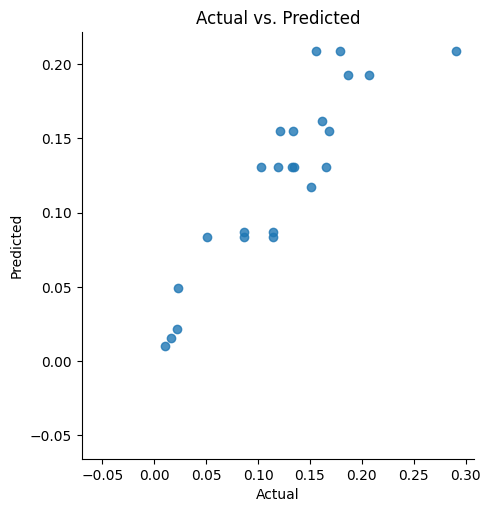

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.2028040670359075
Residuals are normally distributed


/tmp/ipykernel_3429/2009388479.py:173: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


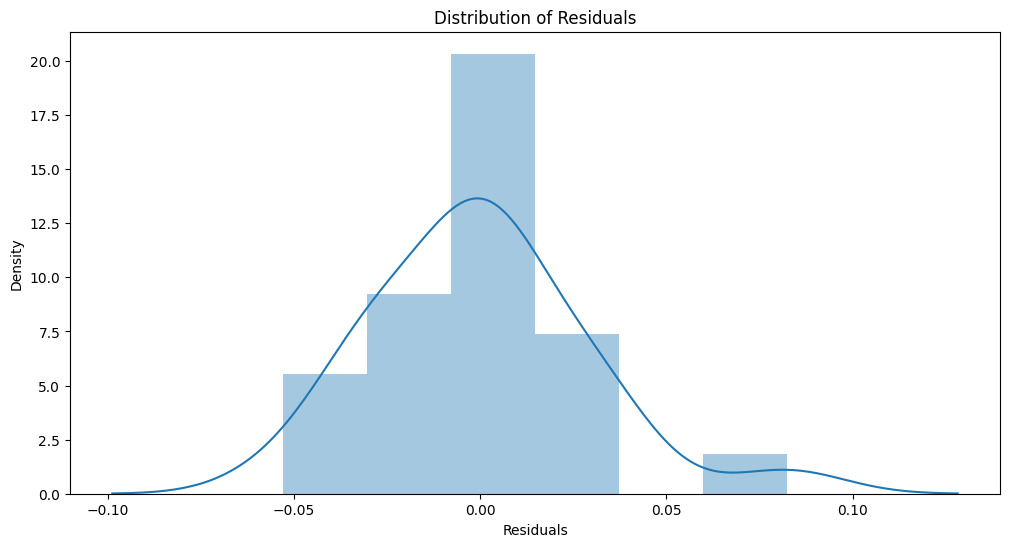


Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


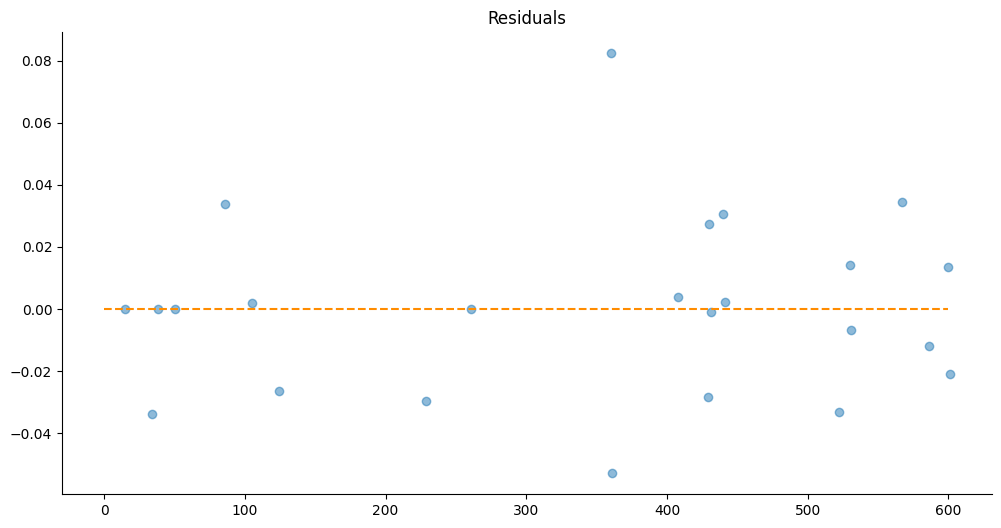

Assumption 3: Little to no multicollinearity among predictors


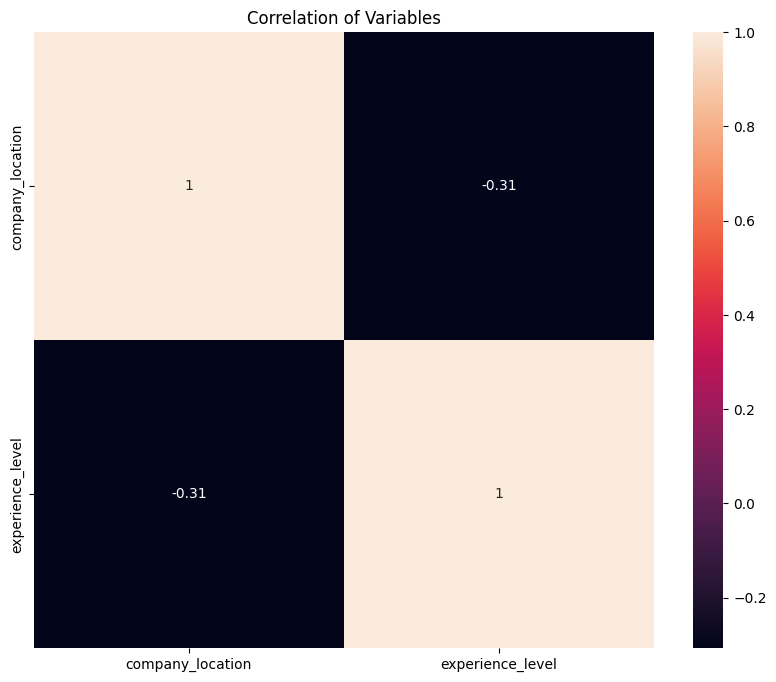

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
company_location: 0.32262455758235775
experience_level: 1.3680914783555675

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.64117785626017
Signs of negative autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


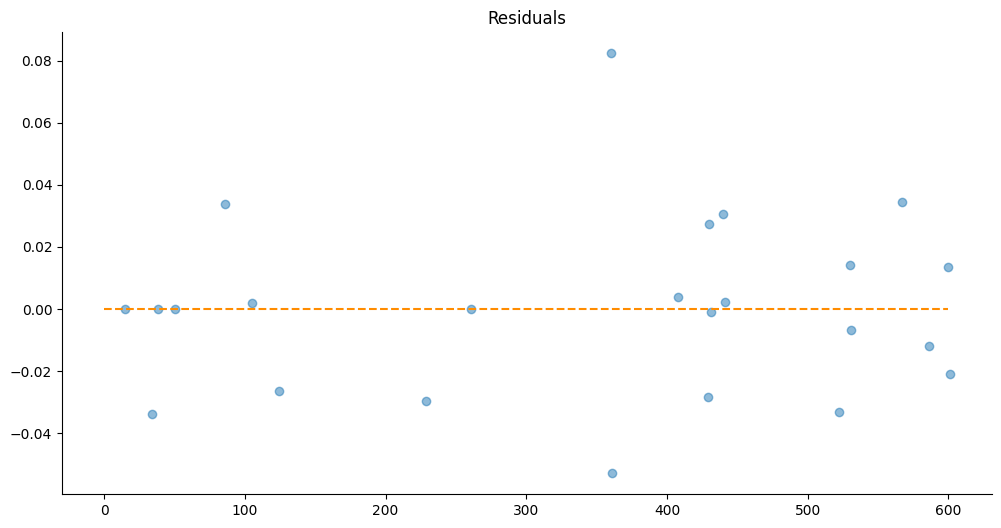

In [74]:
linear_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
normal_errors_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
multicollinearity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"], ["company_location", "experience_level"])
autocorrelation_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])

# Model for the US


In [75]:
var = df[(df["job_title"] == "Data Analyst")  & (df["company_location"] == "US")]

for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes


for col in ["company_location", "work_year", "experience_level", "company_size", "employment_type"]:
    print(var[col].value_counts())

0    56
Name: company_location, dtype: int64
2    41
1    12
0     3
Name: work_year, dtype: int64
3    34
2    14
0     6
1     2
Name: experience_level, dtype: int64
1    43
0     9
2     4
Name: company_size, dtype: int64
0    56
Name: employment_type, dtype: int64


In [76]:
print(len(var))
formula = 'salary_in_usd_yeojohnson ~  C(experience_level) + C(company_location)' # formula                                        
model = ols(formula,var).fit()
print(model.summary())

56
                               OLS Regression Results                               
Dep. Variable:     salary_in_usd_yeojohnson   R-squared:                       0.207
Model:                                  OLS   Adj. R-squared:                  0.161
Method:                       Least Squares   F-statistic:                     4.513
Date:                      Tue, 13 Sep 2022   Prob (F-statistic):            0.00690
Time:                              21:51:00   Log-Likelihood:                 85.463
No. Observations:                        56   AIC:                            -162.9
Df Residuals:                            52   BIC:                            -154.8
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


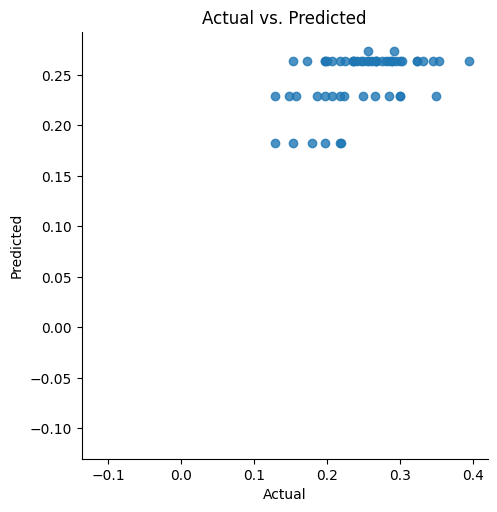

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9892994472384725
Residuals are normally distributed


/tmp/ipykernel_3429/2009388479.py:173: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


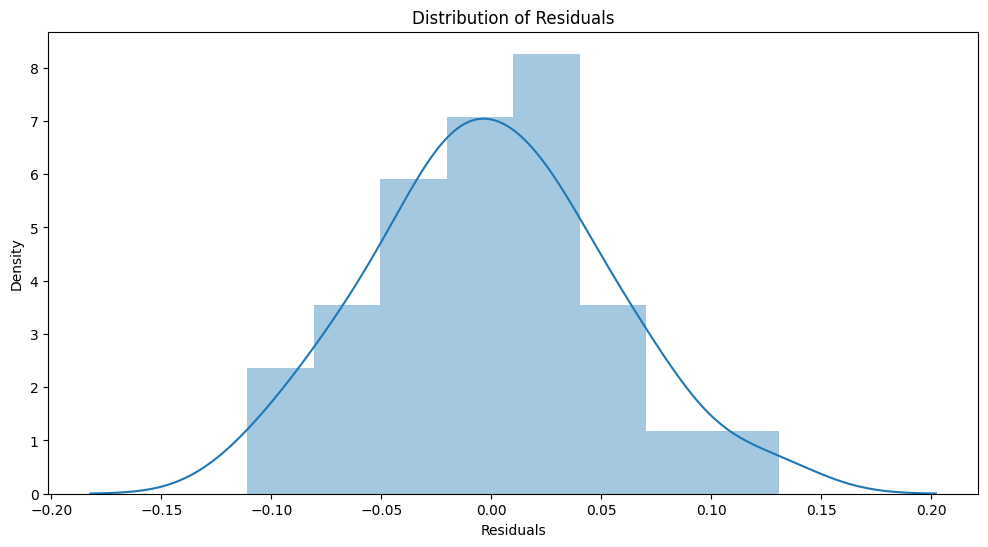


Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


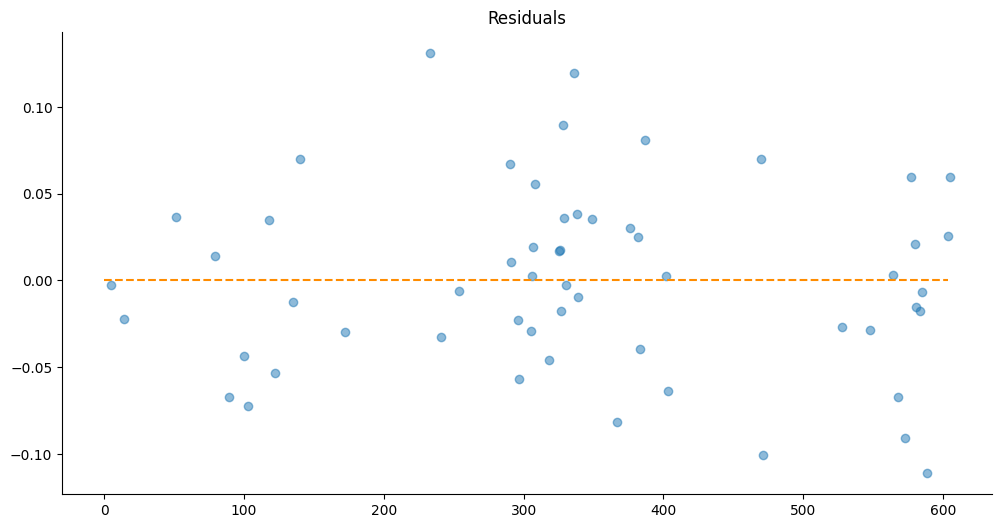

Assumption 3: Little to no multicollinearity among predictors


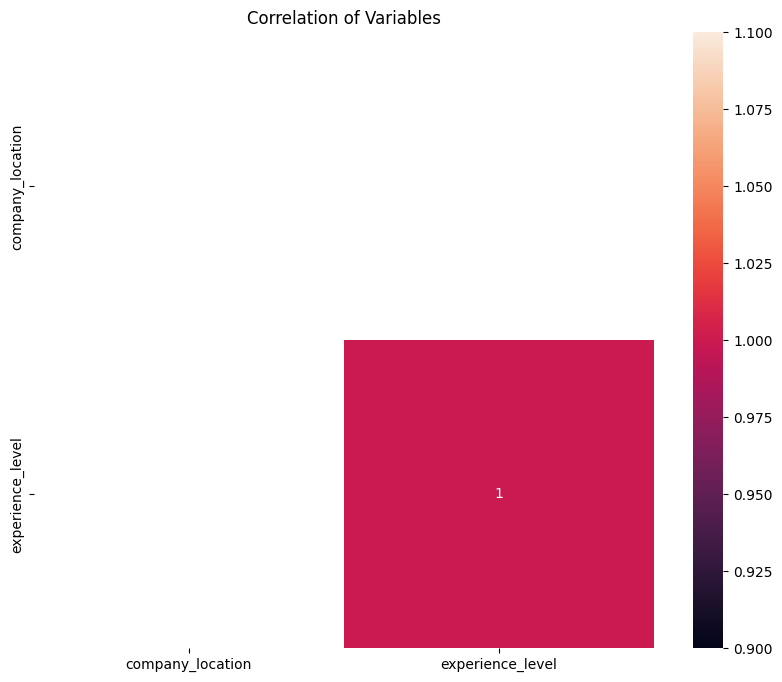

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
company_location: nan
experience_level: 0.2967032967032967

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.2294741962880216
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


/home/repos/mysql/school/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


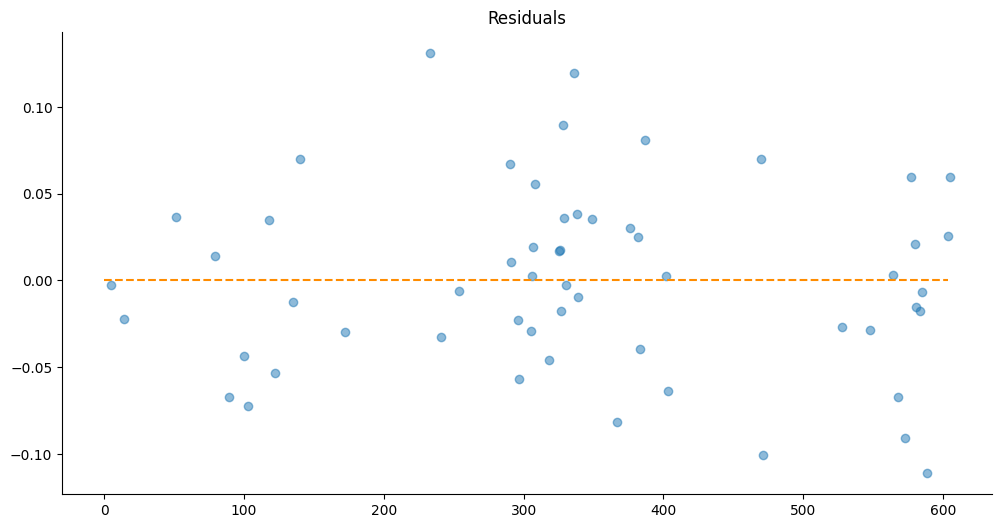

In [77]:
linear_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
normal_errors_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
multicollinearity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"], ["company_location", "experience_level"])
autocorrelation_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])
homoscedasticity_assumption(model, var[["company_location", "experience_level"]], var["salary_in_usd_yeojohnson"])

Todo lo que estuvimos observando me lleva a pensar que el tener tanta data categórica y desbalanceo nos llevaría a que un modelo de árbol tuviera un mejor éxito prediciendo el salario de un científico de datos, pero así mismo me gustaría tener más datos para probar mi idea de que estados unidos necesita su modelo separado.

# Validation of the best variables 

In [78]:
data = df[df["job_title"] == "Data Analyst"]

for col in data.select_dtypes(include="object"):
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.codes
    
X = data[["company_location", "work_year", "experience_level", "company_size", "employment_type"]]
y = data["salary_in_usd_yeojohnson"]

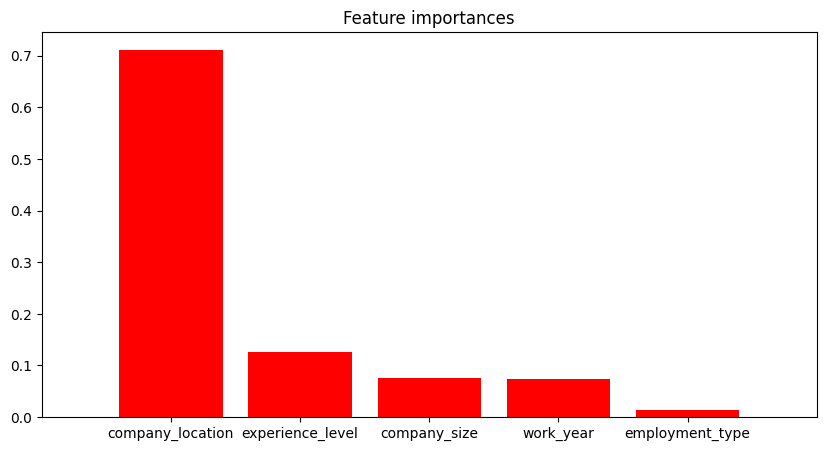

In [79]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X, y)

importances = sel.estimator_.feature_importances_
names = sel.estimator_.feature_names_in_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [names[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()

# Validation of best variable non US

In [80]:
var = df[(df["job_title"] == "Data Analyst")  & (df["company_location"] != "US")]

for col in data.select_dtypes(include="object"):
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.codes
X = data[["company_location", "work_year", "experience_level", "company_size", "employment_type"]]
y = data["salary_in_usd_yeojohnson"]

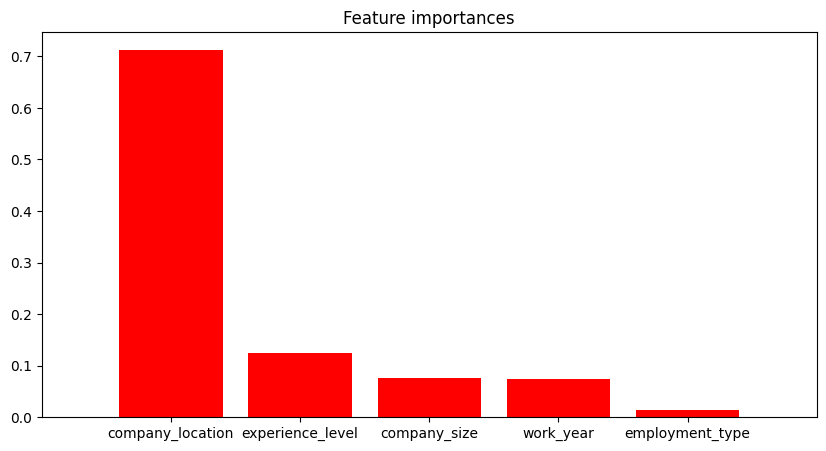

In [81]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X, y)

importances = sel.estimator_.feature_importances_
names = sel.estimator_.feature_names_in_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [names[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()

# Validation of best variable just US

In [82]:
var = df[(df["job_title"] == "Data Analyst")  & (df["company_location"] == "US")]
for col in data.select_dtypes(include="object"):
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.codes
X = data[["work_year", "experience_level", "company_size", "employment_type"]]
y = data["salary_in_usd_yeojohnson"]

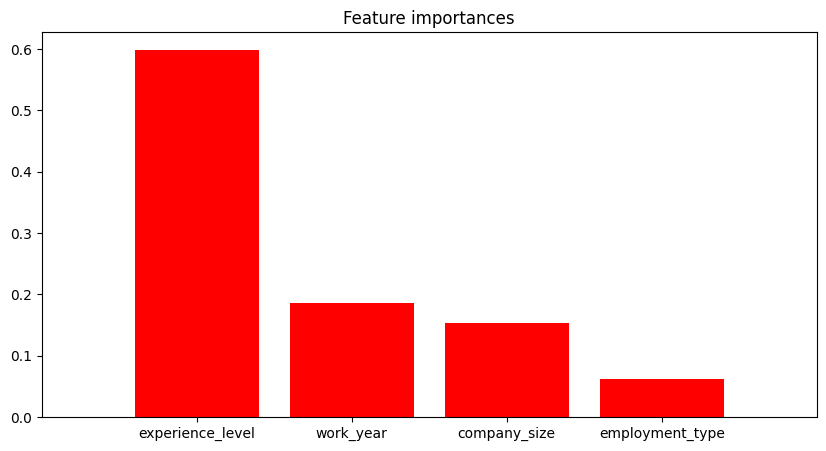

In [83]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X, y)

importances = sel.estimator_.feature_importances_
names = sel.estimator_.feature_names_in_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [names[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()